# Capstone Project 1 Machine Learning/Forecasting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from pandas.tools.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

## Data Extraction

For this analysis, I want to take the mean housing price by zip code for each county and create a separate data set for each county. I then want to use the first 70% of each set and use it to train an ARIMA model. Instead of starting my model from January 2010, I'm going to start at January 2012 because the ARIMA model requires the data to be stationary. Starting from January 2010 makes it difficult to get the data to be stationary.

In [3]:
# Read in dataset
df = pd.read_csv('../data/by_zip.csv', index_col = [0,1], header=[0])
df = df.loc[:,'2012-01-01':]
df.head()

2012-01-01  2012-02-01  2012-03-01  2012-04-01  \
CountyName RegionName                                                   
Alameda    94501         514800.0    514700.0    517800.0    522900.0   
           94502         468700.0    468600.0    472600.0    478600.0   
           94536         488100.0    489600.0    492700.0    496500.0   
           94538         411900.0    414000.0    417600.0    421100.0   
           94539         841300.0    844600.0    853100.0    863800.0   

                       2012-05-01  2012-06-01  2012-07-01  2012-08-01  \
CountyName RegionName                                                   
Alameda    94501         528500.0    533400.0    540200.0    549000.0   
           94502         481300.0    482200.0    486900.0    495300.0   
           94536         499400.0    502300.0    508000.0    516100.0   
           94538         425100.0    430100.0    436400.0    442700.0   
           94539         877100.0    892900.0    907800.0    916600.0   

                       2012-09-01  2012-10-01     ...      2017-08-01  \
CountyName RegionName                             ...                   
Alameda    94501         560700.0    574900.0     ...          970400   
           94502         505500.0    518100.0     ...          876300   
           94536         527600.0    540200.0     ...          963200   
           94538         450700.0    460500.0     ...          880900   
           94539         925800.0    937500.0     ...         1592800   

                       2017-09-01  2017-10-01  2017-11-01  2017-12-01  \
CountyName RegionName                                                   
Alameda    94501           982900      994200     1003400     1012700   
           94502           885000      897300      903700      906500   
           94536           973000      984100      996400     1010700   
           94538           890800      904100      919500      935800   
           94539          1604800     1621900     1640700     1659300   

                       2018-01-01  2018-02-01  2018-03-01  2018-04-01  \
CountyName RegionName                                                   
Alameda    94501          1027300     1042800     1052400     1054800   
           94502           913800      924200      923600      921000   
           94536          1030900     1052700     1066600     1079100   
           94538           955800      976100      989000      998900   
           94539          1685100     1713300     1729500     1736000   

                       2018-05-01  
CountyName RegionName              
Alameda    94501          1054100  
           94502           921400  
           94536          1092200  
           94538          1008300  
           94539          1742000  

[5 rows x 77 columns]

In [4]:
# Group by CountyName
df_grouped = df.groupby('CountyName').mean()
df_grouped.head()

2012-01-01    2012-02-01    2012-03-01    2012-04-01  \
CountyName                                                              
Alameda        4.859643e+05  4.863619e+05  4.893429e+05  4.938190e+05   
Contra Costa   4.399667e+05  4.418300e+05  4.441300e+05  4.475767e+05   
Marin          8.484000e+05  8.454875e+05  8.452000e+05  8.506812e+05   
Napa           3.988833e+05  3.956833e+05  3.961500e+05  4.027500e+05   
San Francisco  1.106774e+06  1.113505e+06  1.123774e+06  1.136547e+06   

                 2012-05-01    2012-06-01    2012-07-01    2012-08-01  \
CountyName                                                              
Alameda        4.980119e+05  5.018714e+05  5.079262e+05  5.153405e+05   
Contra Costa   4.523933e+05  4.568200e+05  4.617233e+05  4.680733e+05   
Marin          8.589125e+05  8.634812e+05  8.696312e+05  8.773875e+05   
Napa           4.120333e+05  4.204500e+05  4.265833e+05  4.290500e+05   
San Francisco  1.149753e+06  1.165216e+06  1.184100e+06  1.203737e+06   

                 2012-09-01    2012-10-01      ...         2017-08-01  \
CountyName                                     ...                      
Alameda        5.250524e+05  5.360071e+05      ...       9.389721e+05   
Contra Costa   4.752800e+05  4.825767e+05      ...       8.055939e+05   
Marin          8.858500e+05  8.945312e+05      ...       1.428950e+06   
Napa           4.300833e+05  4.355333e+05      ...       7.781571e+05   
San Francisco  1.219711e+06  1.235784e+06      ...       2.054363e+06   

                 2017-09-01    2017-10-01    2017-11-01    2017-12-01  \
CountyName                                                              
Alameda        9.455116e+05  9.556558e+05  9.666628e+05  9.785814e+05   
Contra Costa   8.121758e+05  8.167182e+05  8.203061e+05  8.233758e+05   
Marin          1.430319e+06  1.431781e+06  1.435825e+06  1.440831e+06   
Napa           7.912286e+05  7.991143e+05  7.973571e+05  7.909000e+05   
San Francisco  2.067589e+06  2.088911e+06  2.099684e+06  2.104584e+06   

                 2018-01-01    2018-02-01    2018-03-01    2018-04-01  \
CountyName                                                              
Alameda        9.949140e+05  1.011658e+06  1.020351e+06  1.023660e+06   
Contra Costa   8.294758e+05  8.373545e+05  8.444394e+05  8.498788e+05   
Marin          1.451712e+06  1.470012e+06  1.481212e+06  1.483475e+06   
Napa           7.927714e+05  8.044143e+05  8.165571e+05  8.273714e+05   
San Francisco  2.120200e+06  2.136289e+06  2.147821e+06  2.170021e+06   

                 2018-05-01  
CountyName                   
Alameda        1.026491e+06  
Contra Costa   8.523212e+05  
Marin          1.484131e+06  
Napa           8.363000e+05  
San Francisco  2.192753e+06  

[5 rows x 77 columns]

In [5]:
# Assign each CountyName to its own dataset
alameda = df_grouped.loc['Alameda',]
contra_costa = df_grouped.loc['Contra Costa']
marin = df_grouped.loc['Marin',]
napa = df_grouped.loc['Napa',]
santa_clara = df_grouped.loc['Santa Clara',]
san_fran = df_grouped.loc['San Francisco',]
san_mateo = df_grouped.loc['San Mateo',]
sonoma = df_grouped.loc['Sonoma',]
solano = df_grouped.loc['Solano',]

In [6]:
# Convert indices of each county data set to datetime
county_list = [alameda, contra_costa, marin, napa, santa_clara, san_fran, san_mateo, sonoma, solano]
for county in county_list:
    county.index = pd.to_datetime(county.index)

In [7]:
# Split each CountyName to train and test sets
alameda_train, alameda_test = alameda[:int(len(alameda)*0.7)], alameda[int(len(alameda)*0.7):]
cc_train, cc_test = contra_costa[:int(len(contra_costa)*0.7)], contra_costa[int(len(contra_costa)*0.7):]
marin_train, marin_test = marin[:int(len(marin)*0.7)], marin[int(len(marin)*0.7):]
napa_train, napa_test = napa[:int(len(napa)*0.7)], napa[int(len(napa)*0.7):]
sc_train, sc_test = santa_clara[:int(len(santa_clara)*0.7)], santa_clara[int(len(santa_clara)*0.7):]
sf_train, sf_test = san_fran[:int(len(san_fran)*0.7)], san_fran[int(len(san_fran)*0.7):]
sm_train, sm_test = san_mateo[:int(len(san_mateo)*0.7)], san_mateo[int(len(san_mateo)*0.7):]
sonoma_train, sonoma_test = sonoma[:int(len(sonoma)*0.7)], sonoma[int(len(sonoma)*0.7):]
solano_train, solano_test = solano[:int(len(solano)*0.7)], solano[int(len(solano)*0.7):]

In [8]:
# Create a dictionary with county train/test sets indexed by county name
county_train_test = {'Alameda':[alameda_train, alameda_test, alameda],
                    'Contra Costa':[cc_train, cc_test, contra_costa],
                    'Marin':[marin_train, marin_test, marin],
                    'Napa':[napa_train, napa_test, napa],
                    'Santa Clara':[sc_train, sc_test, santa_clara],
                    'San Francisco':[sf_train, sf_test, san_fran],
                    'San Mateo':[sm_train, sm_test, san_mateo],
                    'Solano':[solano_train, solano_test, solano],
                    'Sonoma':[sonoma_train, sonoma_test, sonoma]}

## Data Visualization

Below are plots that show the overall trend of the housing price by Bay Area county. Note that the y-axis scales are all different, but they all show an upward trend with no apparent seasonal trend.

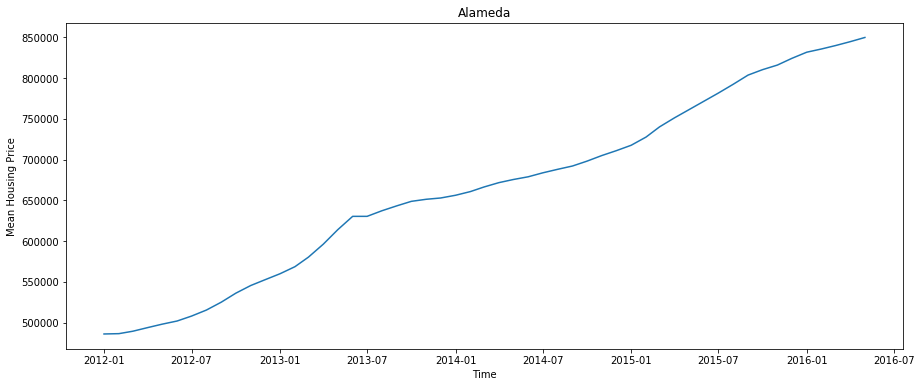

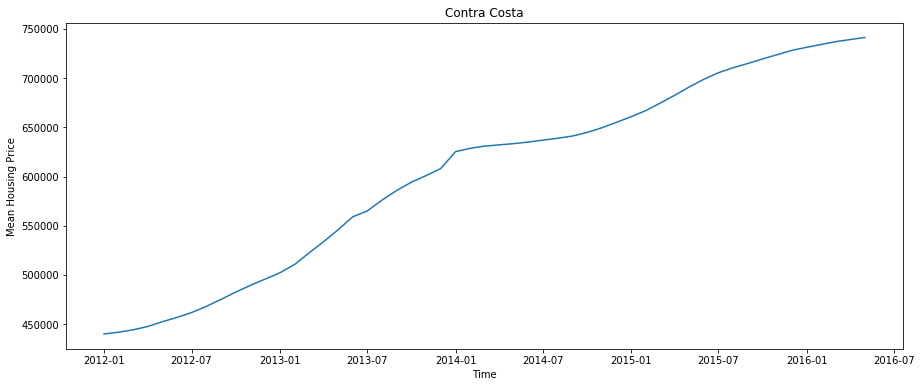

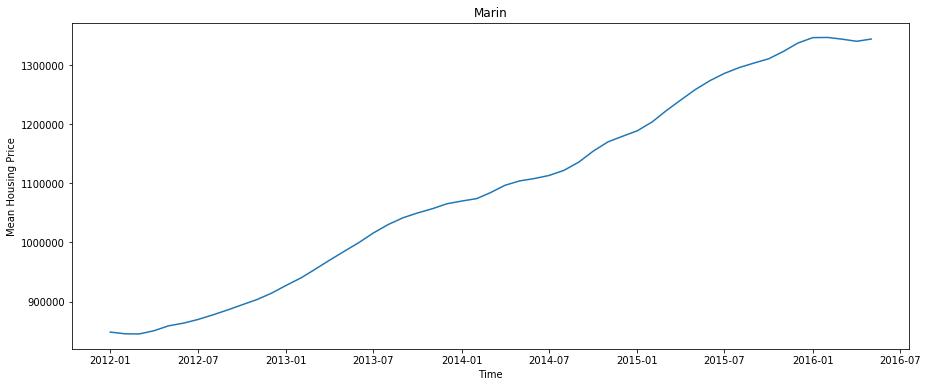

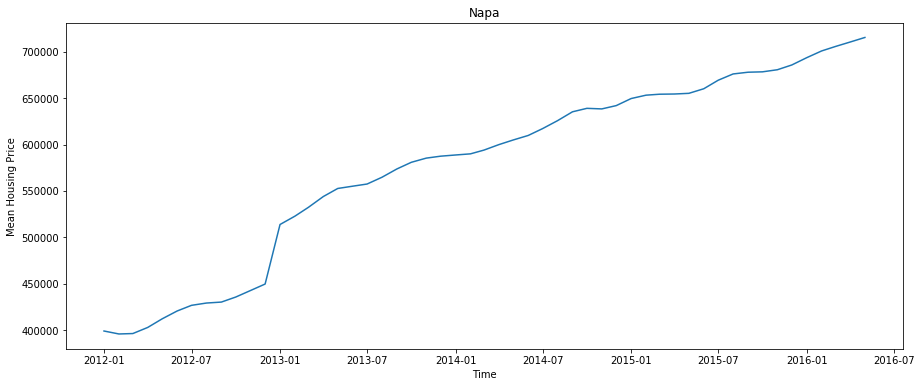

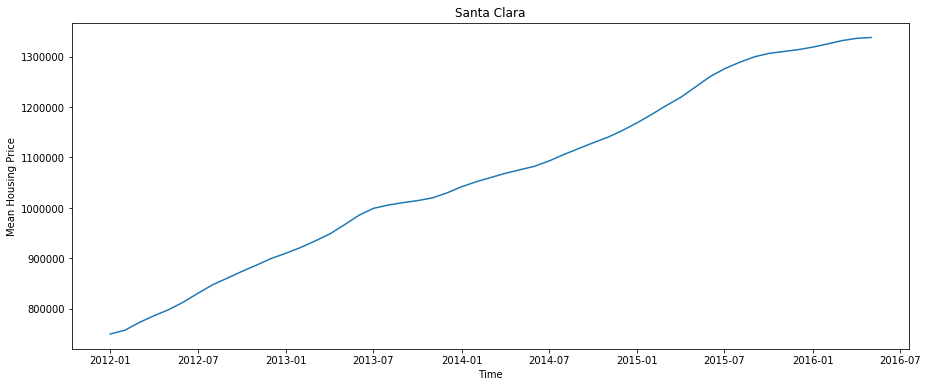

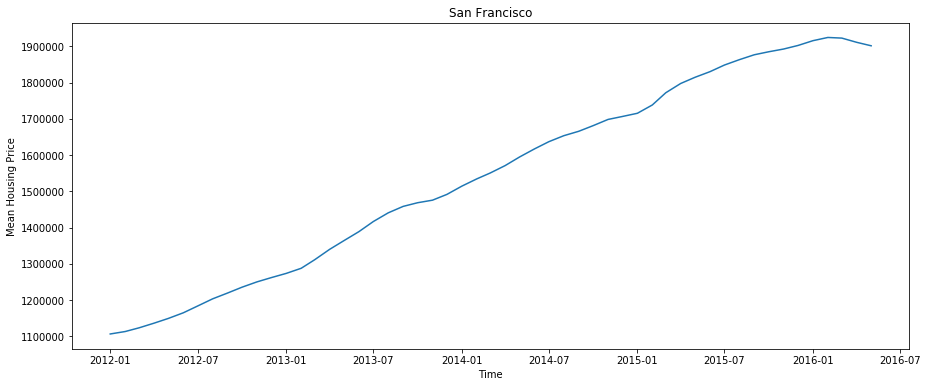

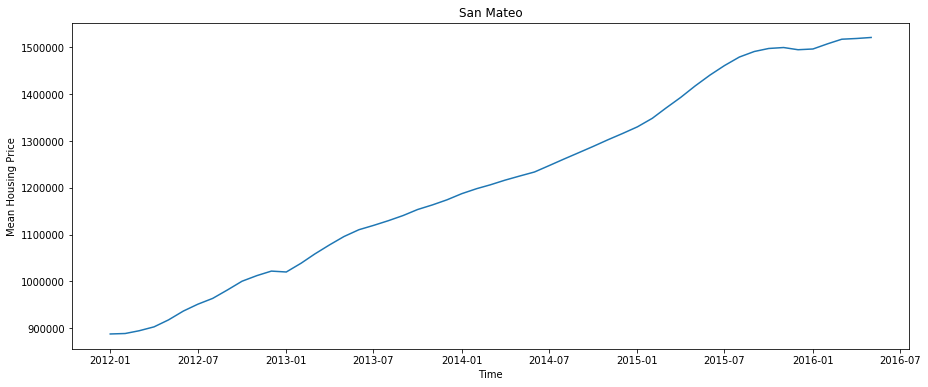

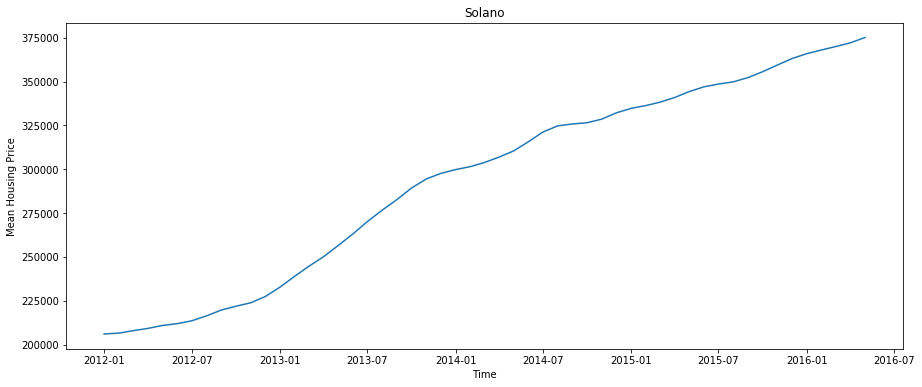

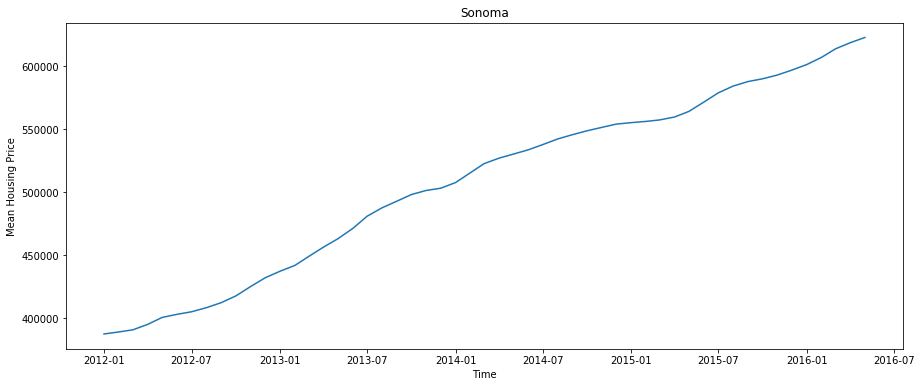

In [9]:
# visualize the time series data
for county in county_train_test:
    plt.plot(county_train_test[county][0])
    plt.title(county)
    plt.xlabel('Time')
    plt.ylabel('Mean Housing Price')
    plt.show()

## Stationary Test

A condition necessary for the ARIMA model is that the data be stationary. A data set is said to be stationary if the following is true over time:
1. constant mean
2. constant variance
3. an autocovariance that doesn't depend on time

There are two methods to validate if a data set is considered stationary, visual inspection and the Dickey-Fuller test. The Dickey-Fuller test is a numerical method to validate a stationary dataset. It assumes a null hypothesis that the data set is not stationary and only with a predetermined significance level, the returning p-value can justify rejecting the null hypothesis. The two functions below can be used to confirm if a dataset is stationary.

In [10]:
# Make the time series data stationary
from statsmodels.tsa.stattools import adfuller

def TestStationaryAdfuller(ts, cutoff = 0.05):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
def TestStationaryPlot(ts, rolling_window = 12):
    rol_mean = ts.rolling(window = rolling_window, center = False).mean()
    rol_std = ts.rolling(window = rolling_window, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.xlabel('Time', fontsize = 12)
    plt.ylabel('Price', fontsize = 12)
    plt.legend(loc='best', fontsize = 12)
    plt.show()

## Inducing a Stationary Dataset

The following methods can be used to imposing a data set to be stationary:
1. Moving Average
2. Exponentially weighted moving average
3. Differencing
4. Decomposing

Each method requires transforming the data to become stationary and each of the following functions takes a data set and transforms it according to one of the methods mentioned. It's also valid to transform the scale of the data such as taking the $log$, $sqrt$, etc.

In [12]:
def moving_avg(dataset, window=12):
    rolling_avg = dataset.rolling(window).mean()
    diff = dataset - rolling_avg
    diff.dropna(inplace=True)
    TestStationaryPlot(diff)
    TestStationaryAdfuller(diff)
    return diff

In [13]:
def weighted_moving_avg(dataset, hl=12):
    exp_weighted_avg = dataset.ewm(halflife=hl).mean()
    diff = dataset - exp_weighted_avg
    diff.dropna(inplace=True)
    TestStationaryPlot(diff)
    TestStationaryAdfuller(diff)
    return diff

In [14]:
def differencing(dataset, s):
    diff = dataset - dataset.shift(s)
    diff.dropna(inplace=True)
    TestStationaryPlot(diff)
    TestStationaryAdfuller(diff)
    return diff

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposing(dataset):
    decomp = seasonal_decompose(dataset)
    
    trend = decomp.trend
    seasonal = decomp.seasonal
    residual = decomp.resid
    
    plt.subplot(411)
    plt.plot(dataset, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    residual.dropna(inplace=True)
    TestStationaryPlot(residual)
    TestStationaryAdfuller(residual)
    
    return residual

## Plot ACF & PACF

The ARIMA model needs the following three parameters to fine-tune the model:
+ $p$: The number of auto-regressive (AR) terms
+ $d$: The number of non-seasonal differences
+ $q$: The number of moving-average (MA) terms.

$d$ can be found by determining how many differences are needed to take from the data to make it stationary. $p$ and $q$ could be determined by the autocorrelation function and partial autocorrelation function. The value at which these functions fall below a given significance level is their corresponding values for the ARIMA model. The user-defined function below plots both plots.

In [16]:
# Plot the correlation and autocorrelation charts
from statsmodels.tsa.stattools import acf, pacf

def acf_pacf(data):
    lag_acf = acf(data, nlags=20)
    lag_pacf = pacf(data, nlags=20, method='ols')

    # Plot ACF
    plt.subplot(1, 2, 1)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y = -1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.title('Autocorrelation Function')

    # Plot PACF
    plt.subplot(1,2,2)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y = -1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()

## Build ARIMA Model

After determining your parameters for you model, it's time to fit it. The following function takes a list all arguments needed to build an ARIMA model and fits it. It'll then return a plot of fitted values to the stationary dataset and the fitted model to perform forecasting.

In [17]:
# Construct the ARIMA model function
def arima_summary(data, stationary, p, d, q):
    model = ARIMA(data, order=(p, d, q))
    model_fit = model.fit(disp=-1)
    print(model_fit.summary())
    
    residuals = model_fit.resid
    residuals_norm = (residuals - residuals.mean())/residuals.std()
    
    plt.subplot(2, 1, 1)
    plt.plot(stationary, color = 'blue', label='Stationary')
    plt.plot(model_fit.fittedvalues, color='red', label='Fitted Values')
    plt.legend(loc='best')
    plt.title('RSS: %.4f' % sum(model_fit.fittedvalues - stationary[0])**2)
    
    plt.subplot(2, 1, 2)
    residuals_norm.plot(kind='kde')
    plt.title('Residual Plot')
    plt.tight_layout()
    plt.show()
    
    print(residuals_norm.describe())
    
    return model_fit

## Forecasting

When a model is created, it's important to see how well the model fits the training data and the testing data. The first function below calculated and plots the fitted values of the model and the original training data. The second plot the original testing data along with forecasted data predicted by the model. The model also calculates a 95% confidence interal of the forecasted data.

In [18]:
# Create a function to make predictions on the model
def ARIMA_predictions(county, model):
    county_train = county_train_test[county][0]
    
    fitted_values = pd.DataFrame(np.exp(model.predict(typ='levels')), index = county_train.index, columns=['Predictions'])
    fitted_values = fitted_values.fillna(county_train[0])
    
    plt.plot(county_train, color='blue', label='Original')
    plt.plot(fitted_values, color = 'red', label='Predicted')
    plt.legend(loc='best')

    plt.title('RMSE: %.4f' %(np.sqrt(sum(fitted_values['Predictions'] - county_train)**2)/len(alameda_train)))
    plt.show()

In [19]:
def forecast_score(county_name, predict_model, ts_steps=24):
    test_df = pd.DataFrame(county_train_test[county_name][1])
    test_values = county_train_test[county_name][1]
    
    model_forecast = predict_model.forecast(steps = ts_steps)
    model_forecast_values = np.exp(model_forecast[0])
    model_forecast_confid = np.exp(model_forecast[2])
    model_forecast_df = pd.DataFrame(model_forecast_values, index=test_df.index, columns=['Predictions'])
    model_forecast_ci_df = pd.DataFrame(model_forecast_confid, index=test_df.index, columns=['Lower', 'Upper'])
    
    fig, ax = plt.subplots()
    plt.plot(county_train_test[county_name][2], color='blue', label='Test Data')
    plt.plot(model_forecast_df, color='red', label='Predictions')
    ax.fill_between(model_forecast_ci_df.index,
                    model_forecast_ci_df.iloc[:, 0],
                    model_forecast_ci_df.iloc[:, 1], color='r', alpha=.5)
    plt.legend(loc='best')
    plt.title('%s Test vs. Predictions' %(county_name))
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()
    
    forecast_rsme = np.sqrt(mean_squared_error(test_df, model_forecast_df))
    mean_pct_error = np.mean(np.abs(model_forecast_values - test_values.values)/test_values.values)
    
    print('Test RSME: %.4f' %(forecast_rsme))
    print('Average Percent Error: %.4f' %(mean_pct_error))

## Bay Area Housing Analysis

Now that all the functions necessary for this analysis have been created, it's time to apply them to the Bay Area housing data. I first wanted to see how stationary each of the county data sets were (see below).

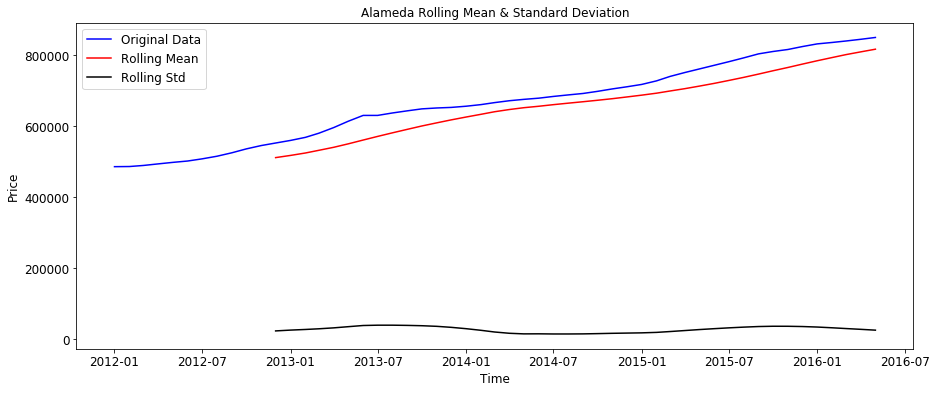

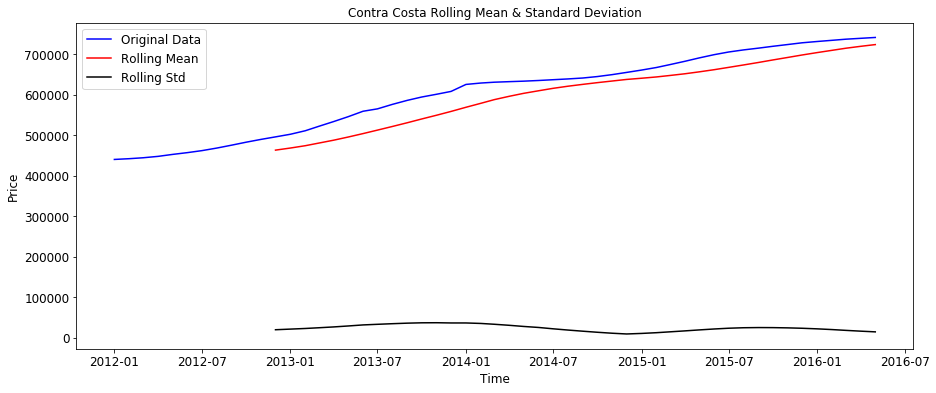

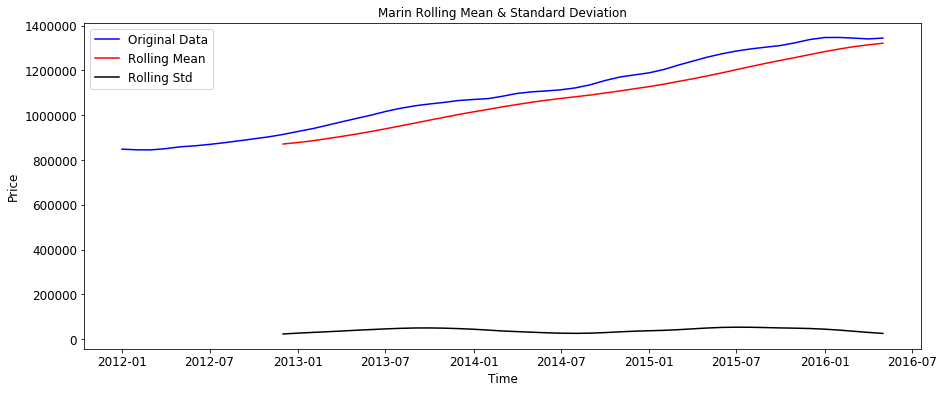

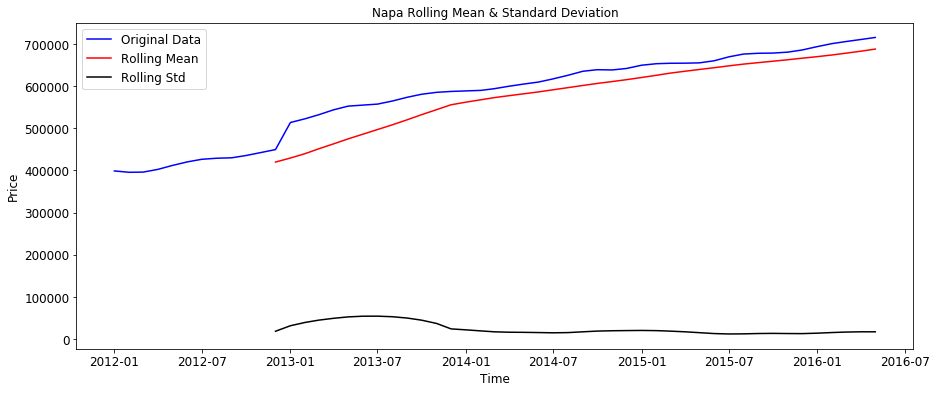

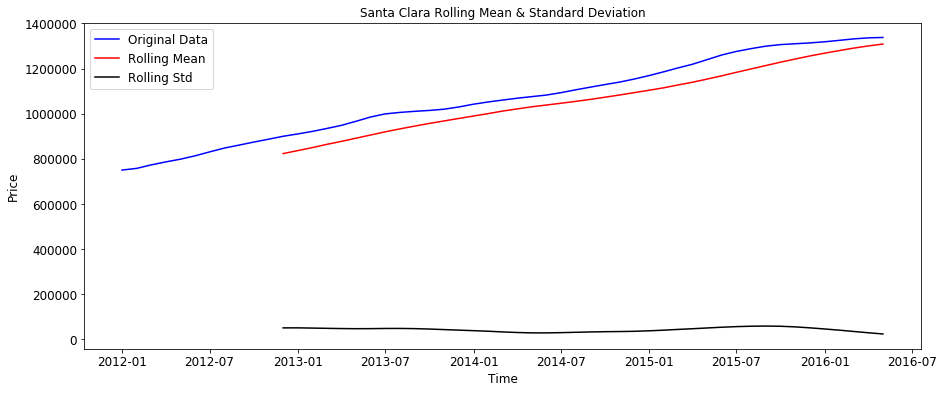

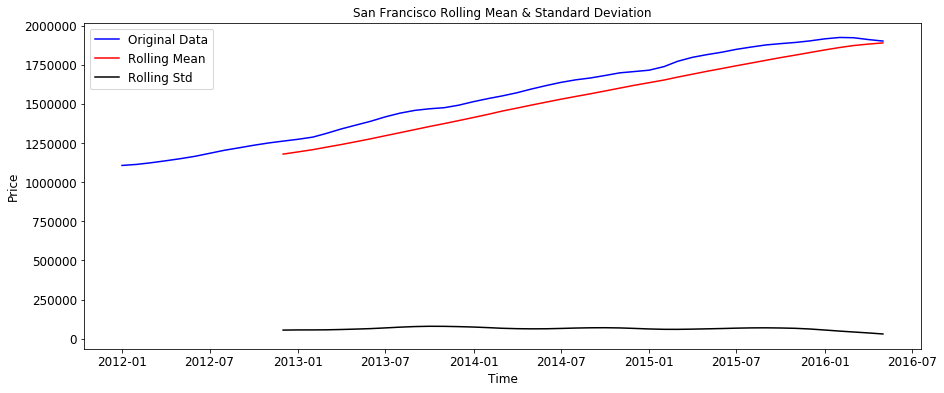

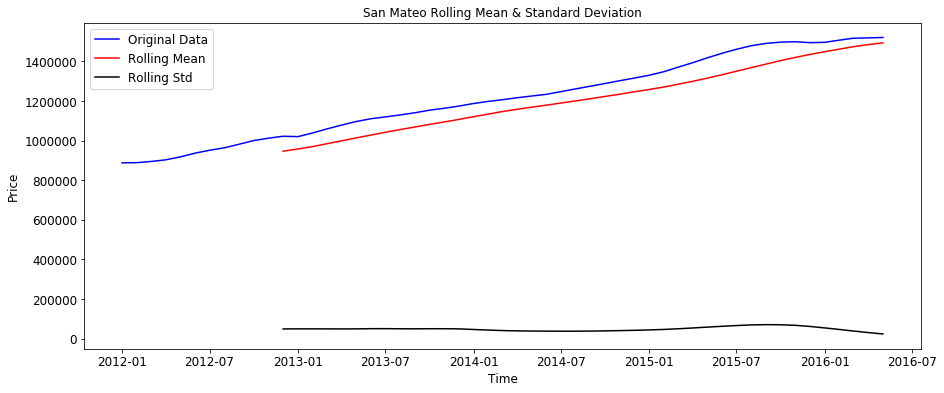

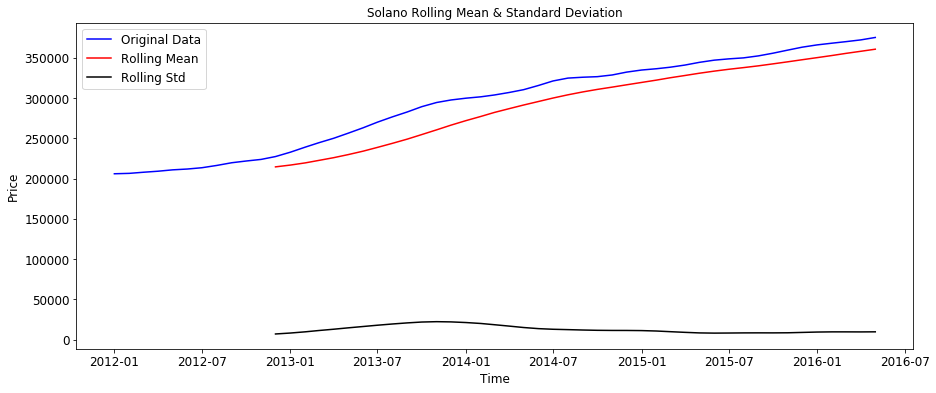

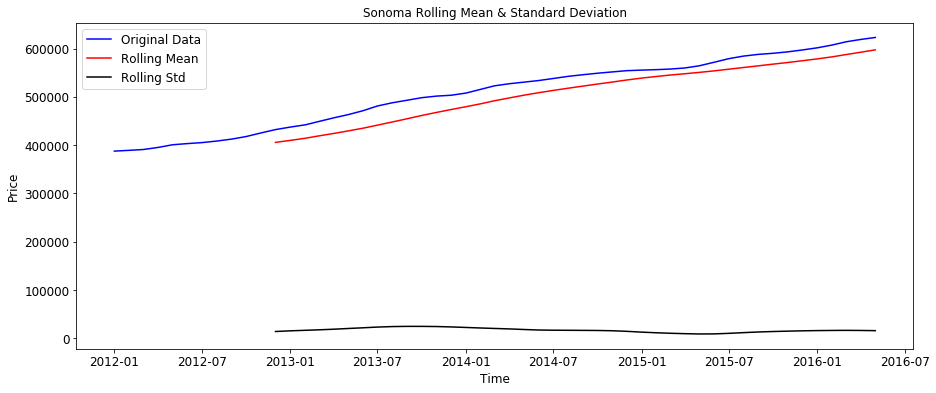

In [20]:
for county in county_train_test:
    plt.title("%s Rolling Mean & Standard Deviation" %(county), fontsize = 12)
    TestStationaryPlot(county_train_test[county][0], rolling_window=12)

In [21]:
for county in county_train_test:
    print(county)
    TestStationaryAdfuller(county_train_test[county][0])

Alameda
Test Statistic                 -0.765034
p-value                         0.829178
#Lags Used                      1.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
Contra Costa
Test Statistic                 -1.661464
p-value                         0.451069
#Lags Used                      1.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
Marin
Test Statistic                  0.496067
p-value                         0.984753
#Lags Used                     11.000000
Number of Observations Used    41.000000
Cri

According to the Dickey-Fuller tests p-values above, none of the county data sets could be considered stationary with an alpha of $0.05$. Each will have to be transformed to impose the data set to be stationary before they could be analyzed.

### Alameda County

In [22]:
# Take log of data set
alameda_train_log = np.log(alameda_train)

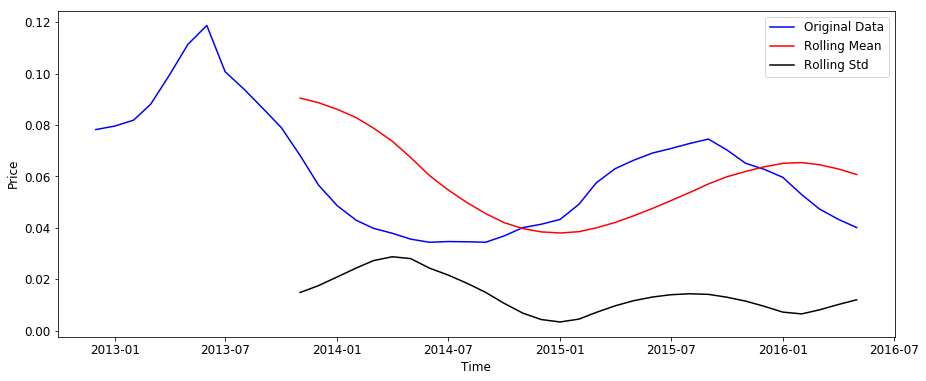

Test Statistic                 -2.239560
p-value                         0.192202
#Lags Used                      3.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [23]:
alameda_ma = moving_avg(alameda_train_log, window=12)

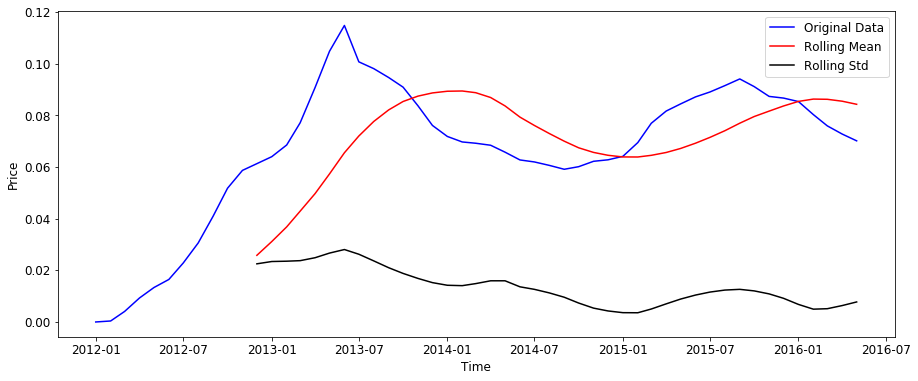

Test Statistic                 -3.004753
p-value                         0.034453
#Lags Used                      1.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [24]:
alameda_wma = weighted_moving_avg(alameda_train_log, hl=6)

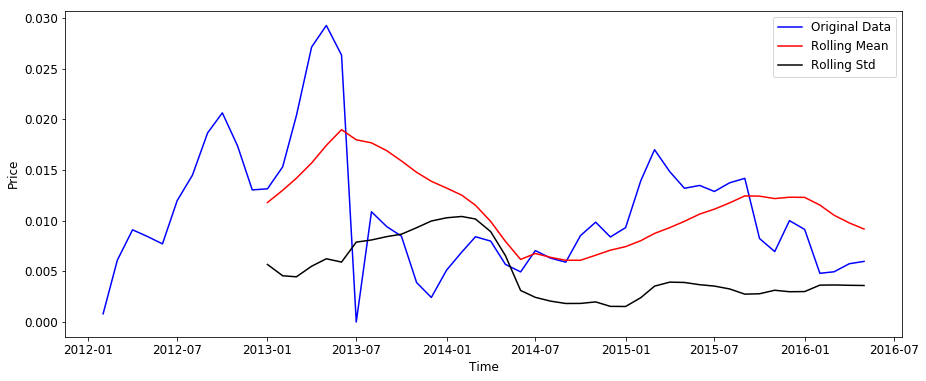

Test Statistic                 -3.154577
p-value                         0.022769
#Lags Used                      0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [25]:
alameda_train_log_diff = differencing(alameda_train_log, 1)

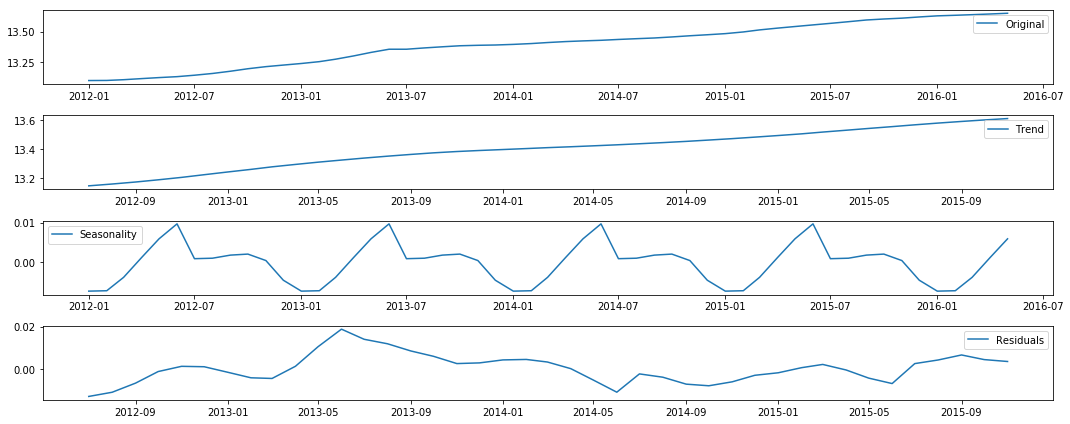

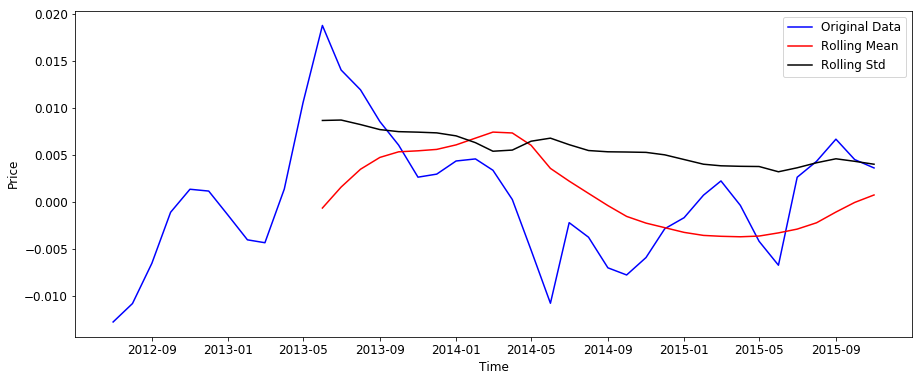

Test Statistic                 -3.222190
p-value                         0.018736
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [26]:
alameda_train_resid = decomposing(alameda_train_log)

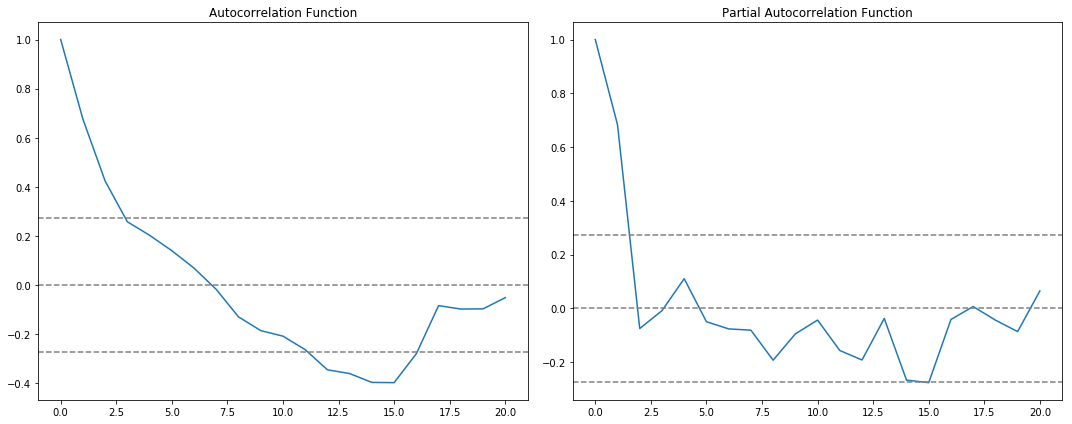

In [27]:
acf_pacf(alameda_train_log_diff)

In [28]:
alameda_train_p = 3
alameda_train_q = 2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.Alameda   No. Observations:                   52
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 208.401
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sat, 21 Mar 2020   AIC                           -402.802
Time:                        16:39:34   BIC                           -389.143
Sample:                    02-01-2012   HQIC                          -397.565
                         - 05-01-2016                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0102      0.002      5.139      0.000       0.006       0.014
ar.L1.D.Alameda    -0.3087      0.175     -1.761      0.085      -0.652       0.035
ar.L2.D.Alameda    -0.1675      

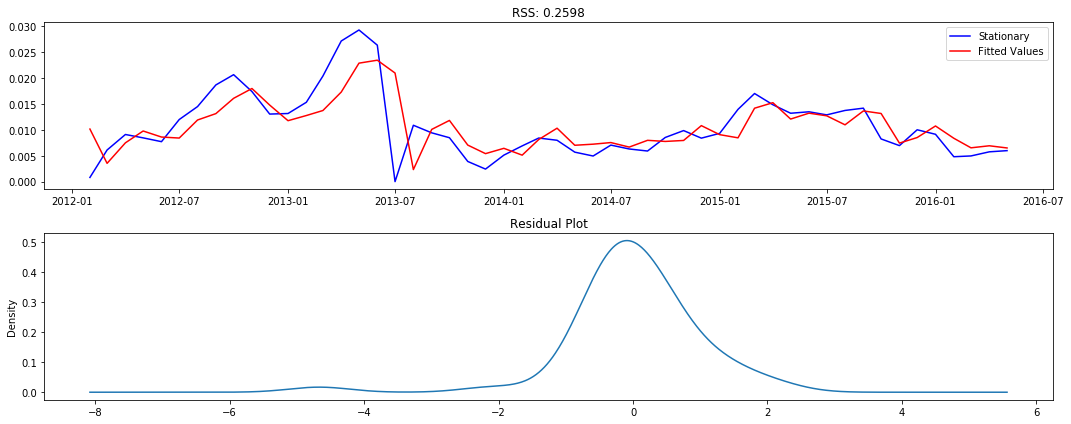

count    5.200000e+01
mean    -2.455301e-17
std      1.000000e+00
min     -4.668648e+00
25%     -3.772647e-01
50%     -4.873797e-02
75%      5.387408e-01
max      2.153316e+00
dtype: float64


In [29]:
alameda_model_fit = arima_summary(alameda_train_log, alameda_train_log_diff, alameda_train_p, 1, alameda_train_q)

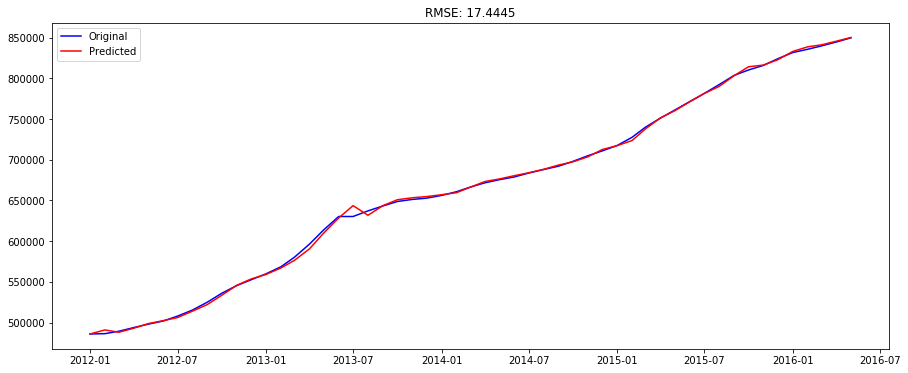

In [30]:
ARIMA_predictions('Alameda', alameda_model_fit)

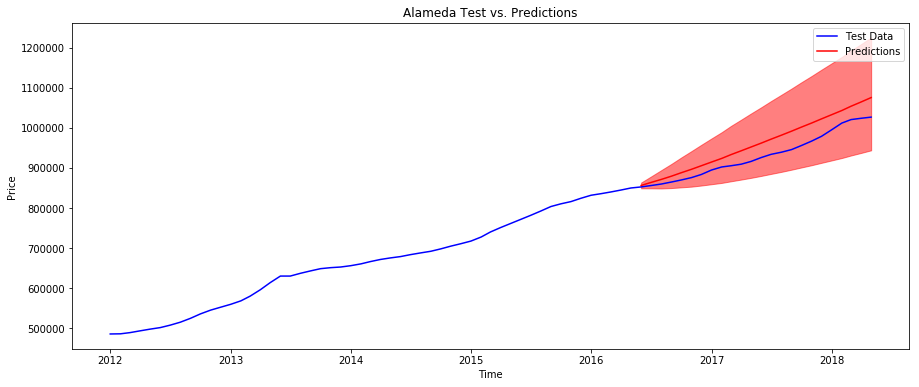

Test RSME: 32833.5954
Average Percent Error: 0.0319


In [31]:
forecast_score('Alameda', alameda_model_fit)

### Contra Costa County

In [32]:
cc_train_log = np.log(cc_train)

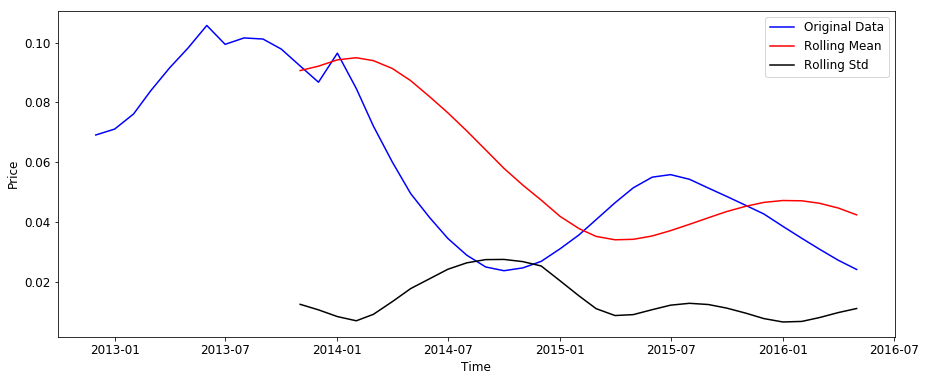

Test Statistic                 -1.647863
p-value                         0.458155
#Lags Used                      2.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [33]:
cc_ma = moving_avg(cc_train_log, window=12)

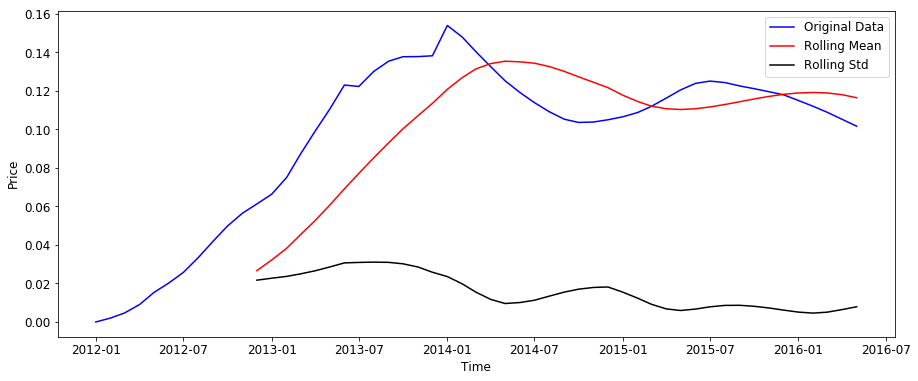

Test Statistic                 -2.763057
p-value                         0.063748
#Lags Used                      2.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [34]:
cc_wma = weighted_moving_avg(cc_train_log, hl=12)

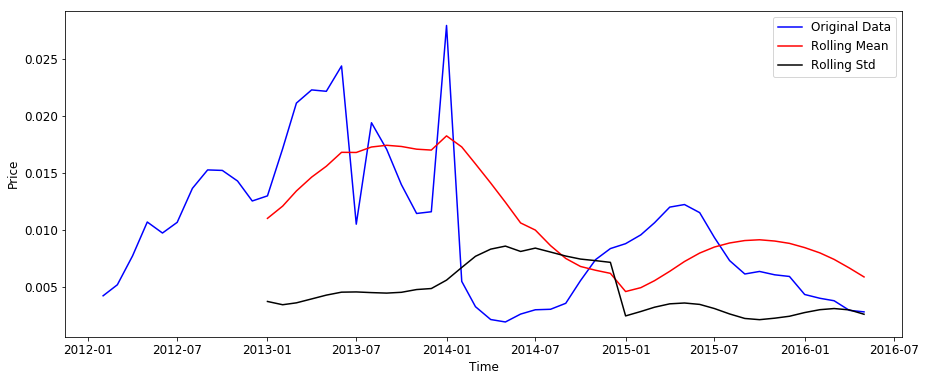

Test Statistic                 -1.978482
p-value                         0.296087
#Lags Used                      1.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [35]:
cc_train_log_diff = differencing(cc_train_log, 1)

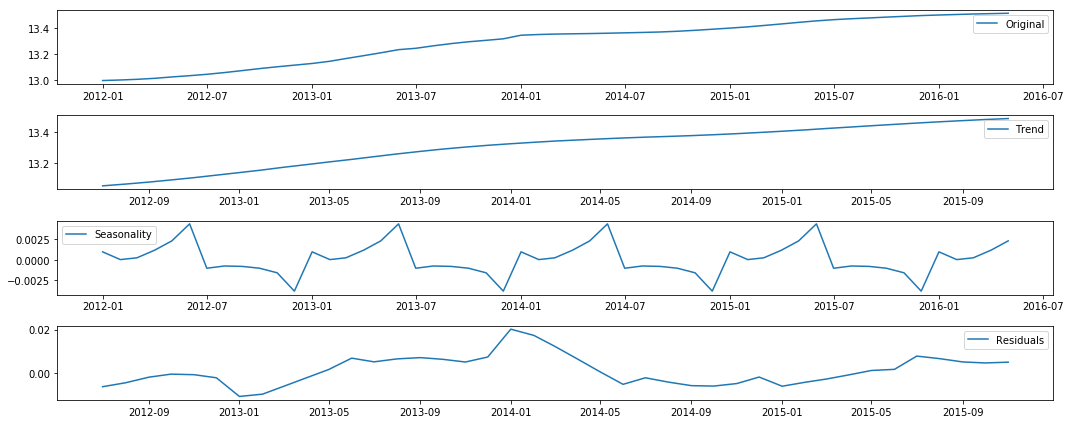

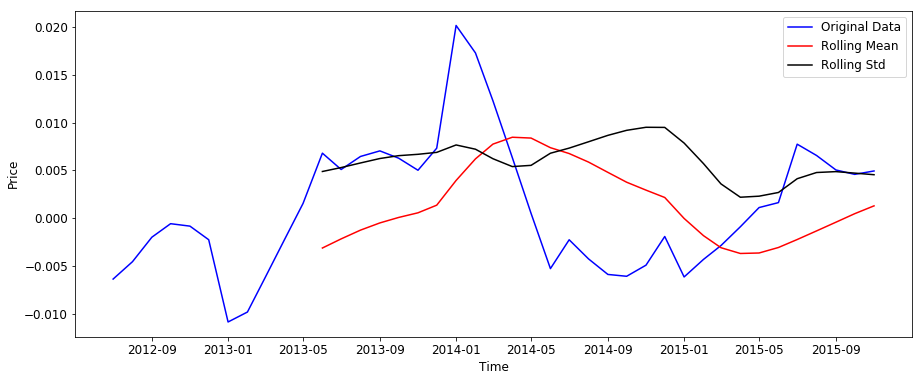

Test Statistic                 -2.400871
p-value                         0.141491
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [36]:
cc_train_resid = decomposing(cc_train_log)

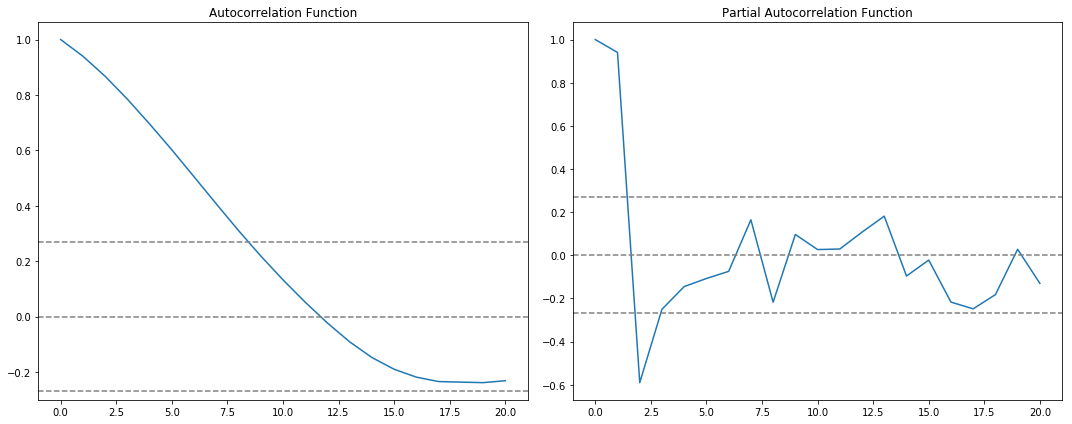

In [37]:
acf_pacf(cc_wma)

In [38]:
cc_train_p=9
cc_train_q =2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D.Contra Costa   No. Observations:                   52
Model:                 ARIMA(9, 1, 2)   Log Likelihood                 213.874
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sat, 21 Mar 2020   AIC                           -401.749
Time:                        16:39:57   BIC                           -376.383
Sample:                    02-01-2012   HQIC                          -392.024
                         - 05-01-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0096      0.001     10.734      0.000       0.008       0.011
ar.L1.D.Contra Costa     0.5319      0.138      3.840      0.000       0.260       0.803
ar.L2.D.Cont

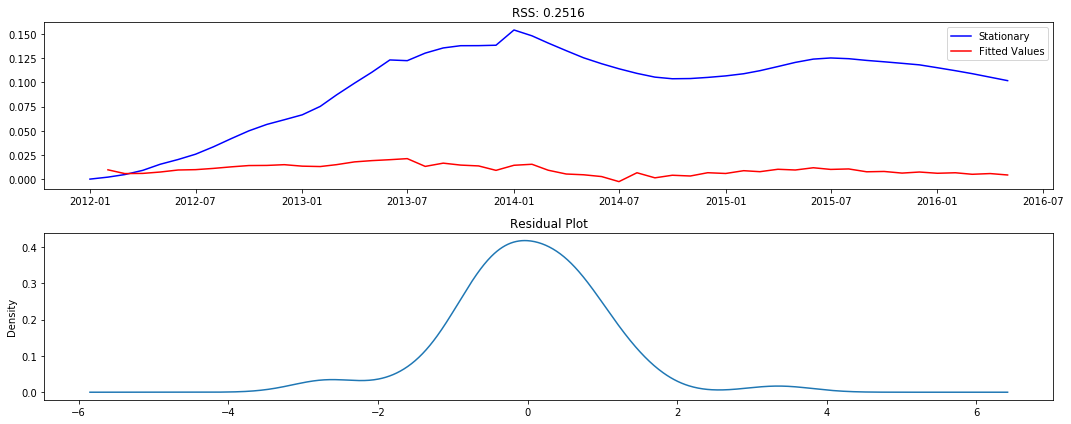

count    5.200000e+01
mean    -2.455301e-17
std      1.000000e+00
min     -2.781638e+00
25%     -4.971738e-01
50%     -3.705128e-02
75%      5.714614e-01
max      3.350555e+00
dtype: float64


In [39]:
cc_model_fit = arima_summary(cc_train_log, cc_wma, cc_train_p, 1, cc_train_q)

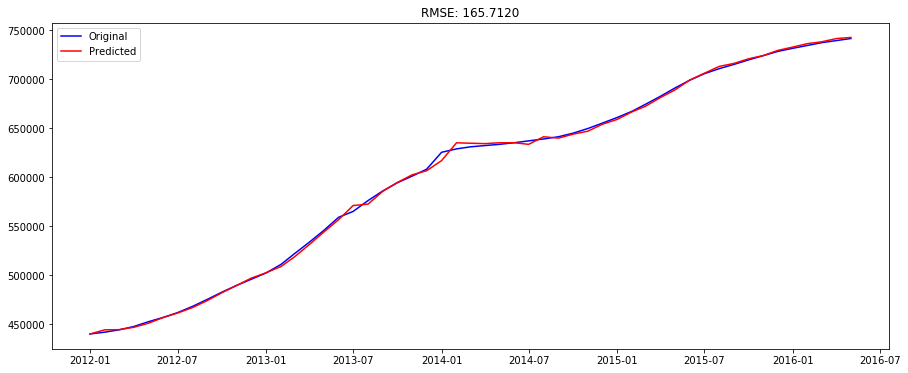

In [40]:
ARIMA_predictions('Contra Costa', cc_model_fit)

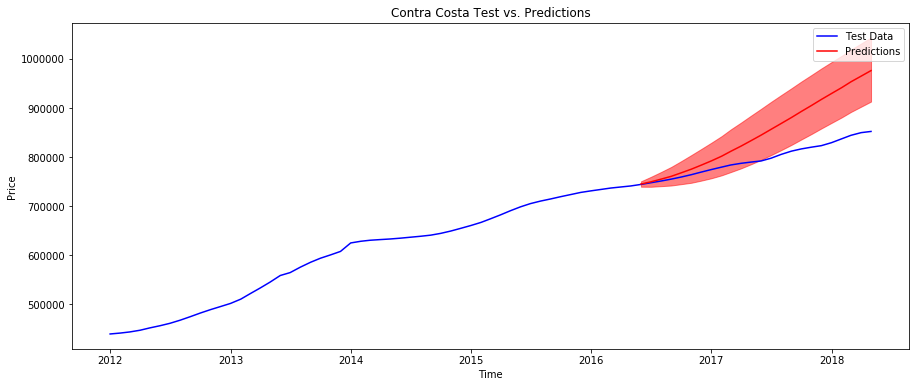

Test RSME: 65574.0335
Average Percent Error: 0.0631


In [41]:
forecast_score('Contra Costa', cc_model_fit)

### Marin County

In [42]:
marin_train_log = np.log(marin_train)

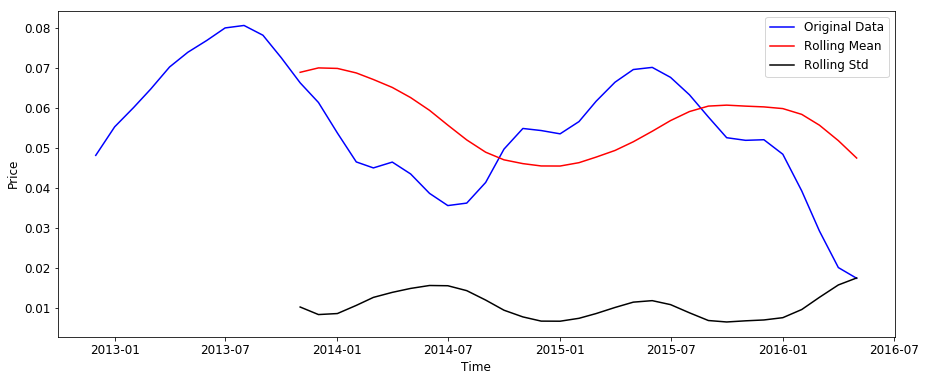

Test Statistic                 -3.757355
p-value                         0.003375
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [43]:
marin_ma = moving_avg(marin_train_log, window=12)

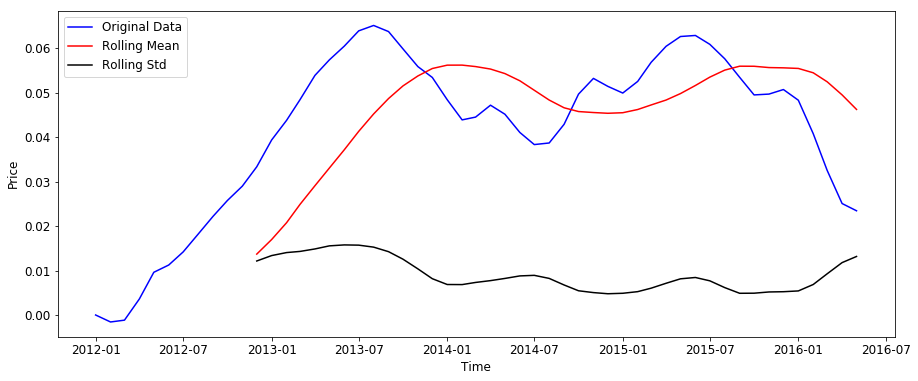

Test Statistic                 -3.477720
p-value                         0.008578
#Lags Used                      5.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [44]:
marin_wma = weighted_moving_avg(marin_train_log, hl=4)

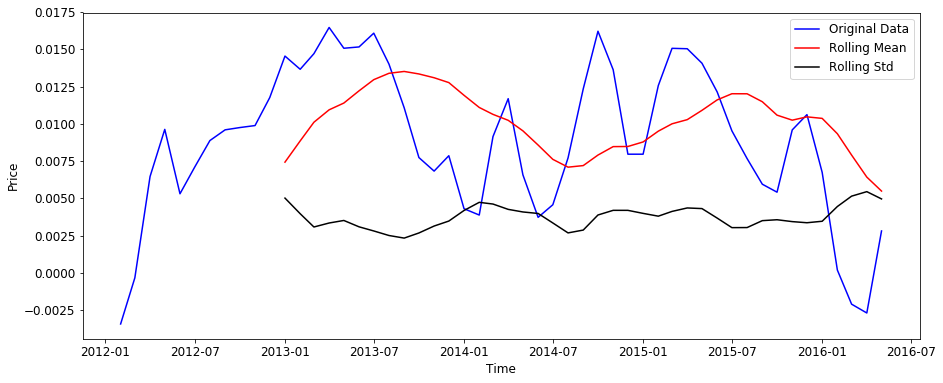

Test Statistic                 -3.340923
p-value                         0.013145
#Lags Used                     10.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [45]:
marin_train_log_diff = differencing(marin_train_log, 1)

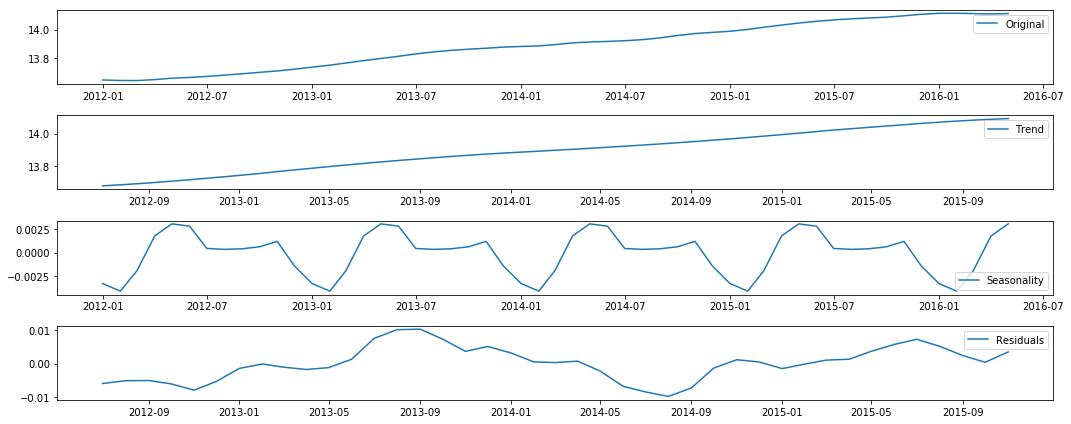

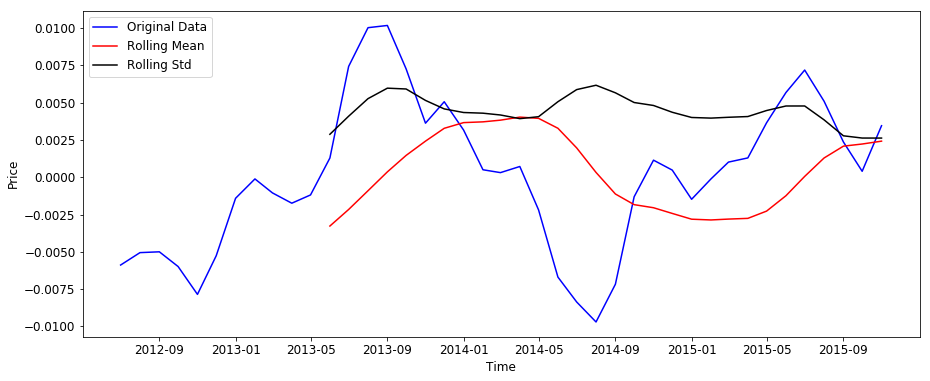

Test Statistic                 -4.331416
p-value                         0.000392
#Lags Used                      9.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [46]:
marin_train_resid = decomposing(marin_train_log)

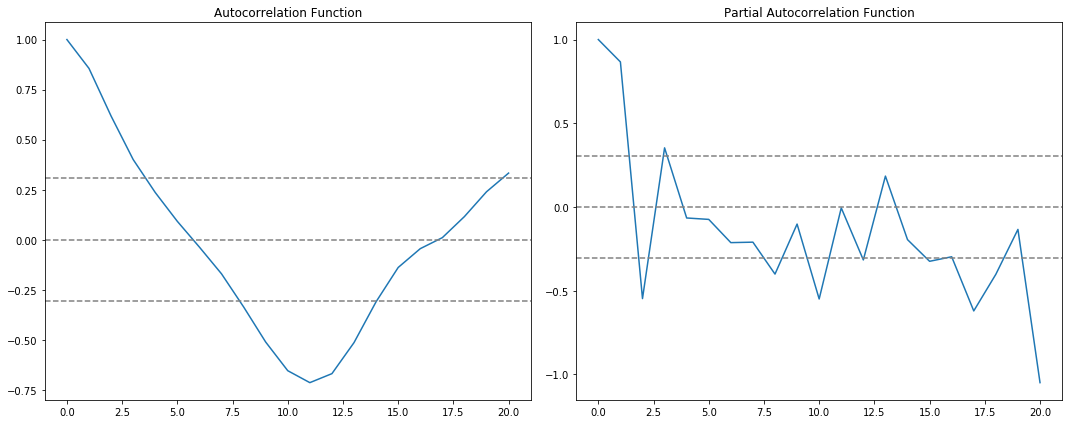

In [47]:
acf_pacf(marin_train_resid)

In [48]:
marin_train_p = 4
marin_train_q = 2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.Marin   No. Observations:                   51
Model:                 ARIMA(4, 2, 2)   Log Likelihood                 239.347
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 21 Mar 2020   AIC                           -462.694
Time:                        16:40:09   BIC                           -447.239
Sample:                    03-01-2012   HQIC                          -456.788
                         - 05-01-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8.238e-05      0.000      0.216      0.830      -0.001       0.001
ar.L1.D2.Marin    -0.8503      0.177     -4.792      0.000      -1.198      -0.503
ar.L2.D2.Marin    -0.4937      0.195

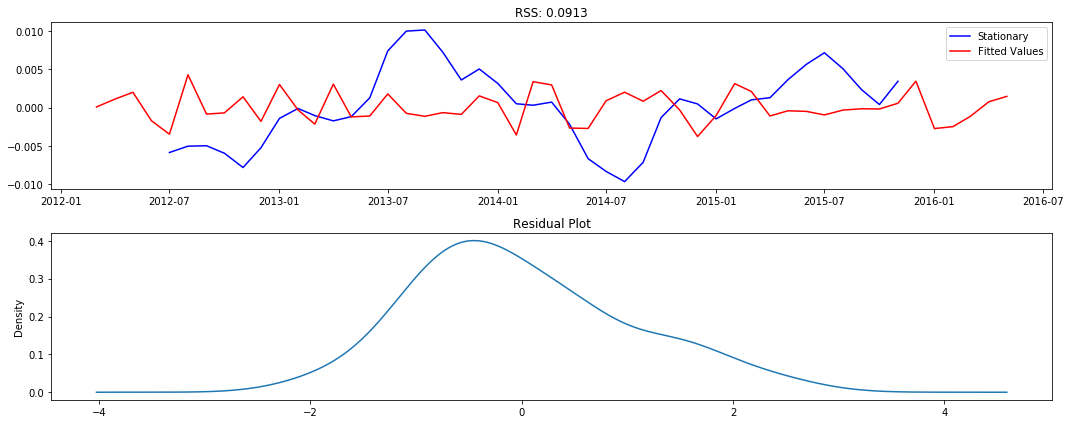

count    5.100000e+01
mean     2.176908e-17
std      1.000000e+00
min     -1.869887e+00
25%     -6.831520e-01
50%     -1.910517e-01
75%      5.397087e-01
max      2.436485e+00
dtype: float64


In [49]:
marin_model_fit = arima_summary(marin_train_log, marin_train_resid, marin_train_p, 2, marin_train_q)

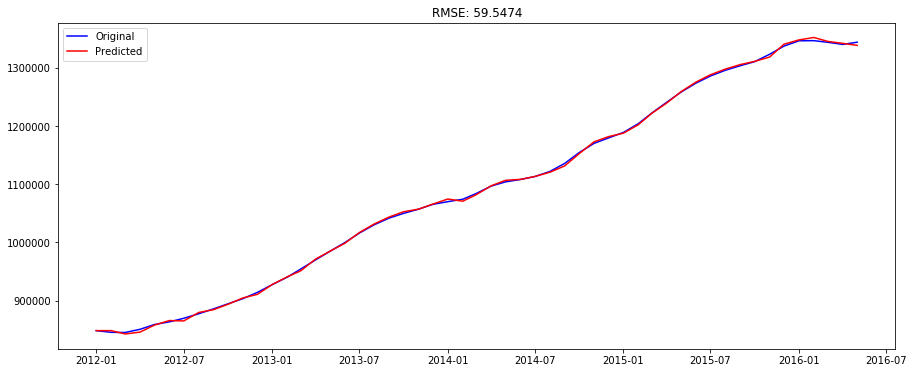

In [50]:
ARIMA_predictions('Marin', marin_model_fit)

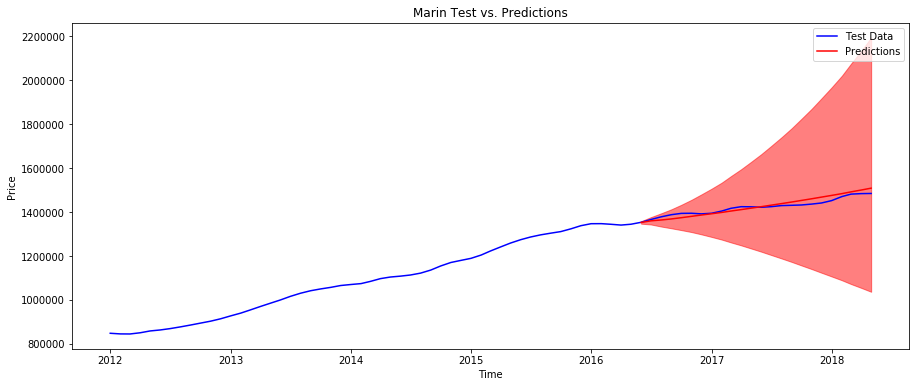

Test RSME: 15022.2916
Average Percent Error: 0.0091


In [51]:
forecast_score('Marin', marin_model_fit)

### Napa County

In [52]:
napa_train_log = np.log(napa_train)

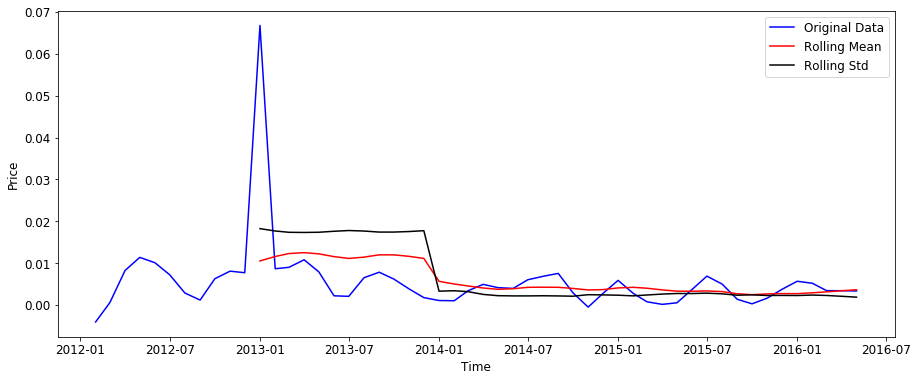

Test Statistic                 -3.327839
p-value                         0.013679
#Lags Used                      2.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [53]:
napa_ma = moving_avg(napa_train_log, window=2)

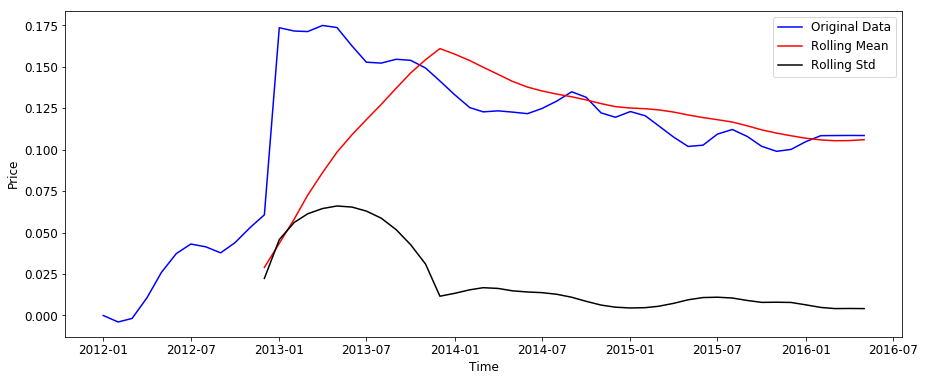

Test Statistic                -6.077464e+00
p-value                        1.112682e-07
#Lags Used                     1.100000e+01
Number of Observations Used    4.100000e+01
Critical Value (1%)           -3.600983e+00
Critical Value (5%)           -2.935135e+00
Critical Value (10%)          -2.605963e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [54]:
napa_wma = weighted_moving_avg(napa_train_log, hl=12)

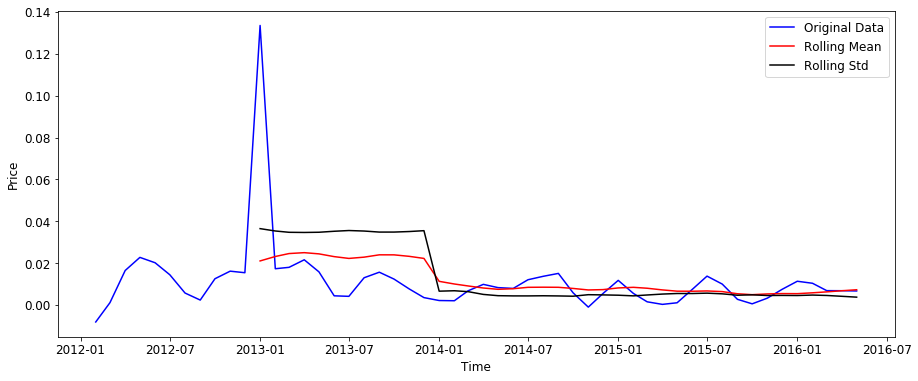

Test Statistic                 -3.327839
p-value                         0.013679
#Lags Used                      2.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [55]:
napa_train_log_diff = differencing(napa_train_log, 1)

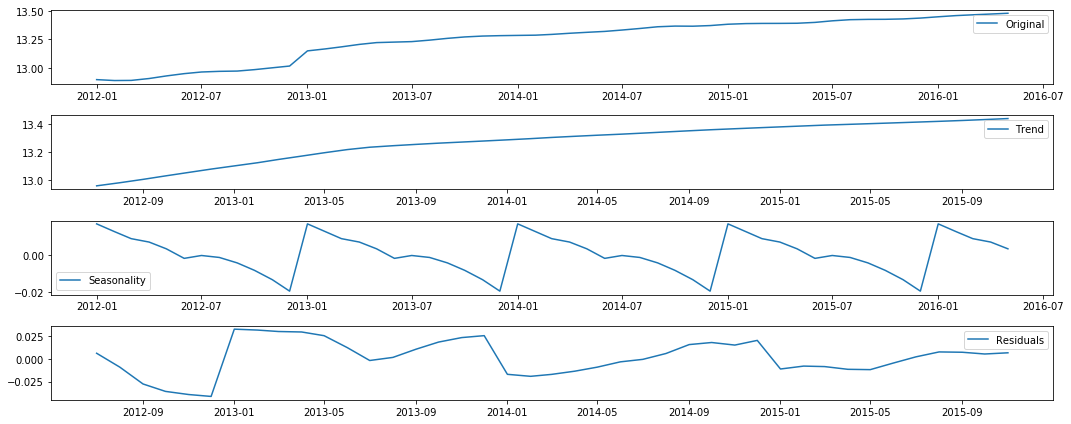

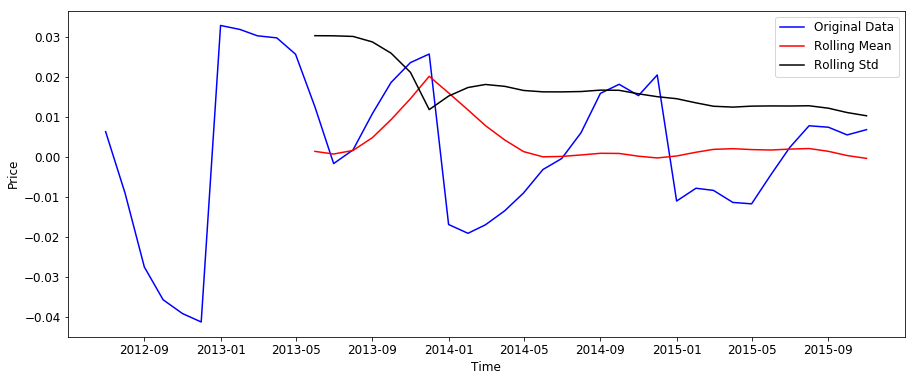

Test Statistic                 -3.221892
p-value                         0.018752
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [56]:
napa_train_resid = decomposing(napa_train_log)

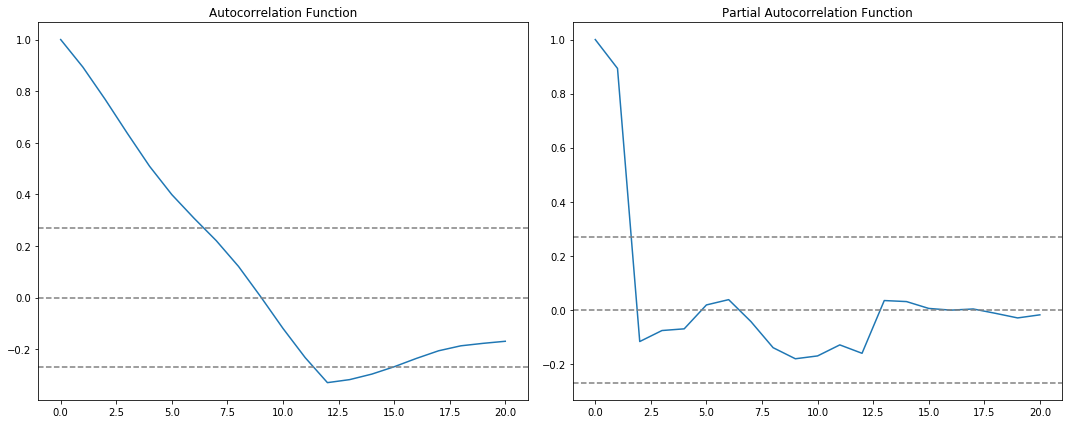

In [57]:
acf_pacf(napa_wma)

In [58]:
napa_train_p = 7
napa_train_q = 2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Curtis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Curtis\Anaconda3\lib\site-packages\scipy\stats\_dis

                             ARIMA Model Results                              
Dep. Variable:                 D.Napa   No. Observations:                   52
Model:                 ARIMA(7, 1, 2)   Log Likelihood                 136.148
Method:                       css-mle   S.D. of innovations              0.017
Date:                Sat, 21 Mar 2020   AIC                           -250.297
Time:                        16:40:19   BIC                           -228.833
Sample:                    02-01-2012   HQIC                          -242.068
                         - 05-01-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0110      0.003      3.338      0.002       0.005       0.017
ar.L1.D.Napa     1.3771      0.162      8.502      0.000       1.060       1.695
ar.L2.D.Napa    -1.0195      0.239     -4.26

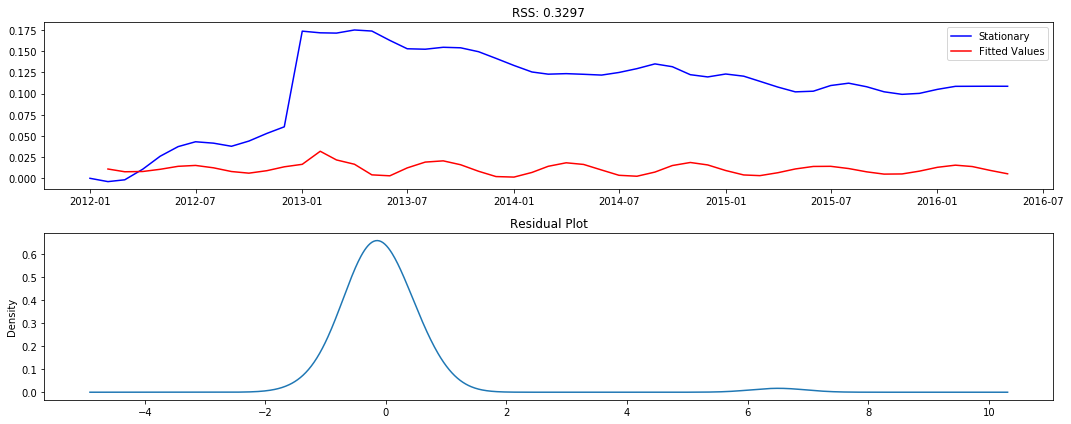

count    5.200000e+01
mean    -6.565261e-17
std      1.000000e+00
min     -1.104079e+00
25%     -3.723069e-01
50%     -1.123300e-01
75%      8.299100e-02
max      6.507623e+00
dtype: float64


In [59]:
napa_model_fit = arima_summary(napa_train_log, napa_wma, napa_train_p, 1, napa_train_q)

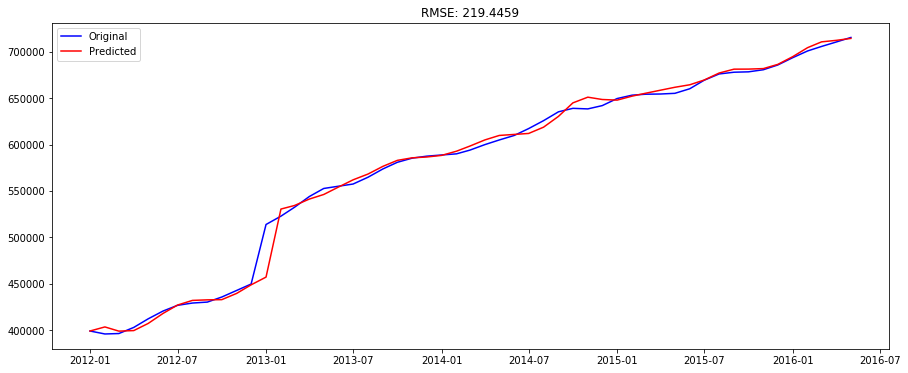

In [60]:
ARIMA_predictions('Napa', napa_model_fit)

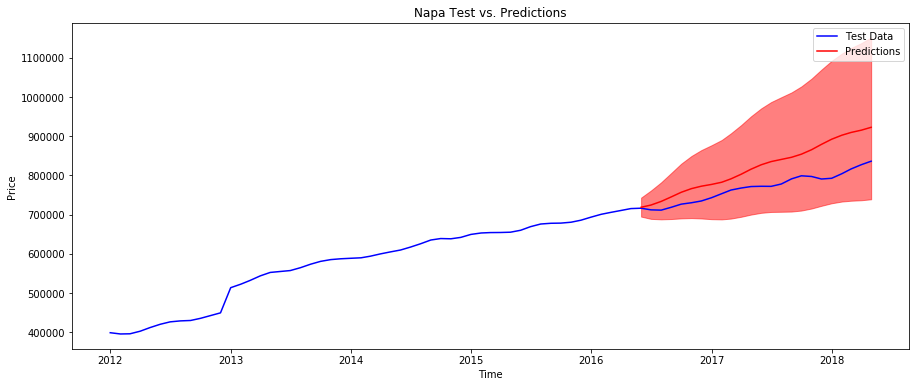

Test RSME: 59141.4870
Average Percent Error: 0.0665


In [61]:
forecast_score('Napa', napa_model_fit)

### San Francisco County

In [62]:
sf_train_log = np.log(sf_train)

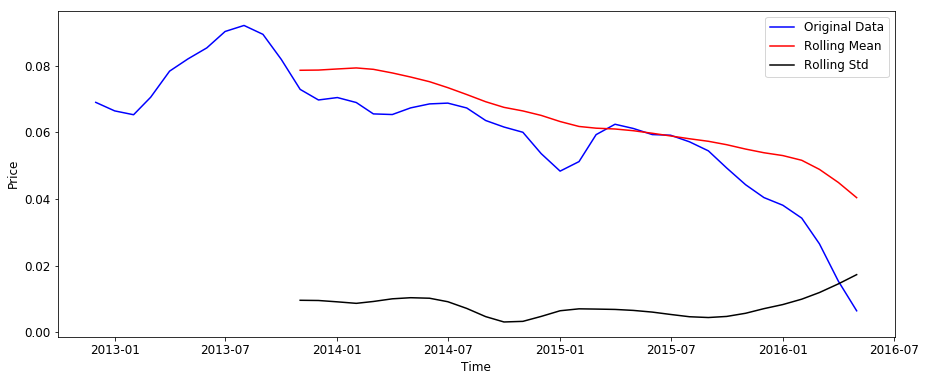

Test Statistic                  1.072210
p-value                         0.994972
#Lags Used                      8.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [63]:
sf_ma = moving_avg(sf_train_log, window=12)

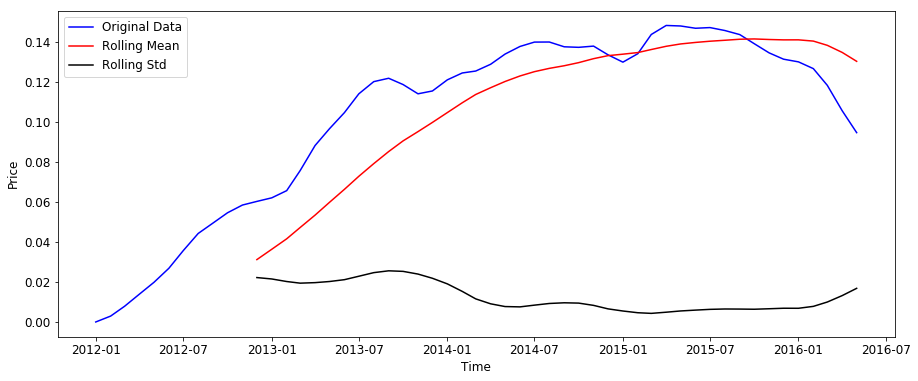

Test Statistic                 -0.936559
p-value                         0.775695
#Lags Used                      8.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [64]:
sf_wma = weighted_moving_avg(sf_train_log, hl=12)

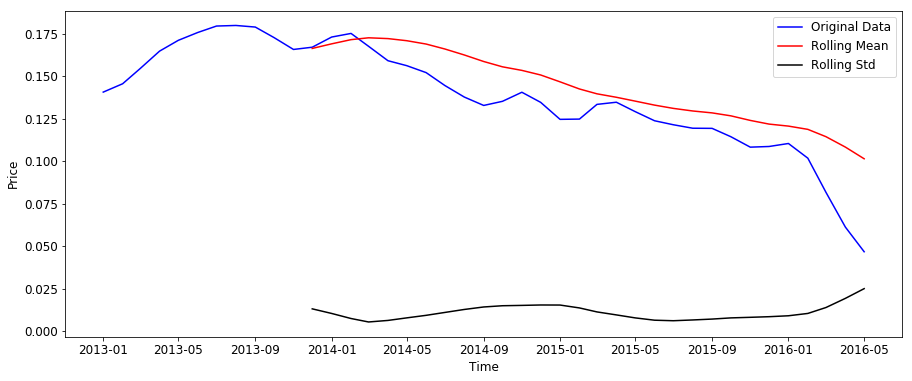

Test Statistic                  1.047349
p-value                         0.994741
#Lags Used                      3.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [65]:
sf_train_log_diff = differencing(sf_train_log, 12)

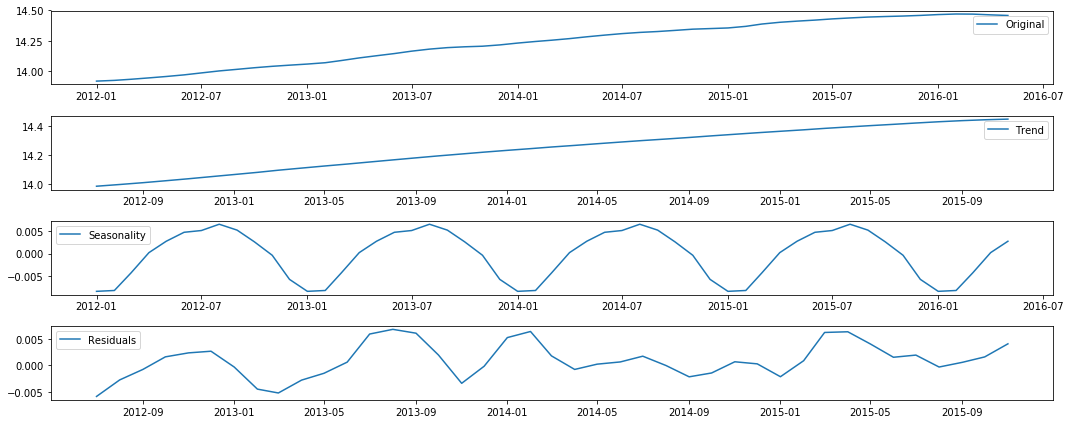

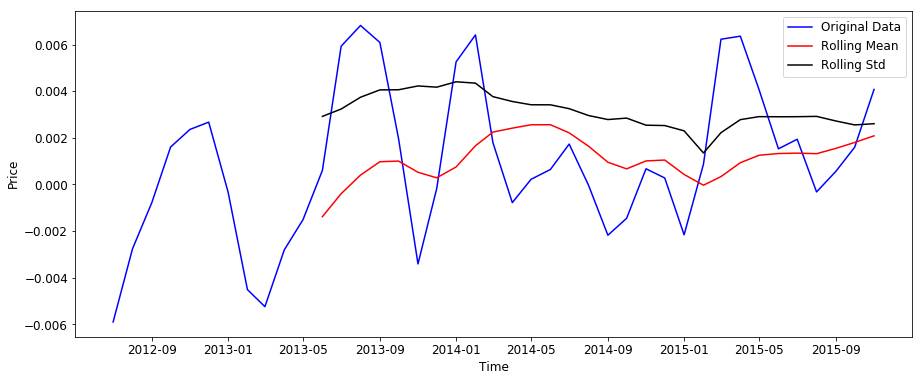

Test Statistic                 -5.227234
p-value                         0.000008
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [66]:
sf_train_resid = decomposing(sf_train_log)

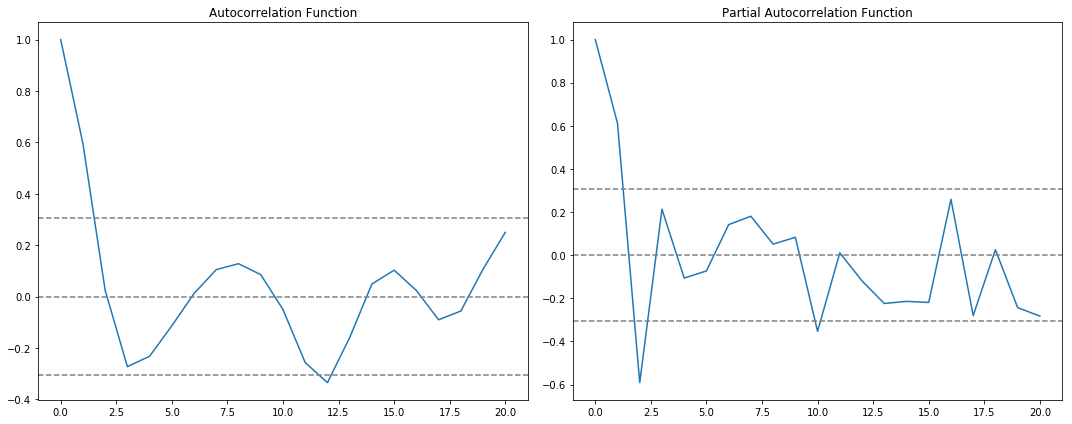

In [67]:
acf_pacf(sf_train_resid)

In [68]:
sf_train_p = 2
sf_train_q = 2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:       D2.San Francisco   No. Observations:                   51
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 234.400
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 21 Mar 2020   AIC                           -456.800
Time:                        16:40:30   BIC                           -445.210
Sample:                    03-01-2012   HQIC                          -452.371
                         - 05-01-2016                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0002      0.000     -0.495      0.623      -0.001       0.001
ar.L1.D2.San Francisco     0.2343      0.315      0.743      0.461      -0.383       0.852
ar.L

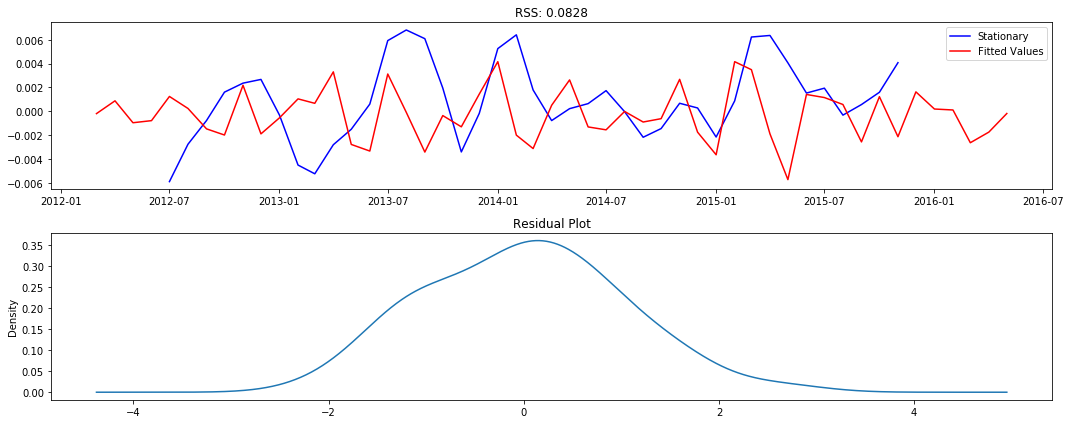

count    5.100000e+01
mean    -8.272250e-17
std      1.000000e+00
min     -2.046081e+00
25%     -7.579730e-01
50%      3.975052e-02
75%      6.436792e-01
max      2.617733e+00
dtype: float64


In [69]:
sf_model_fit = arima_summary(sf_train_log, sf_train_resid, sf_train_p, 2, sf_train_q)

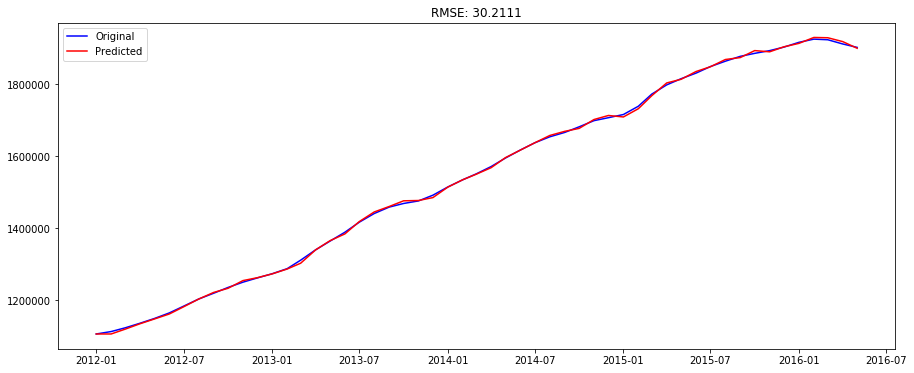

In [70]:
ARIMA_predictions('San Francisco', sf_model_fit)

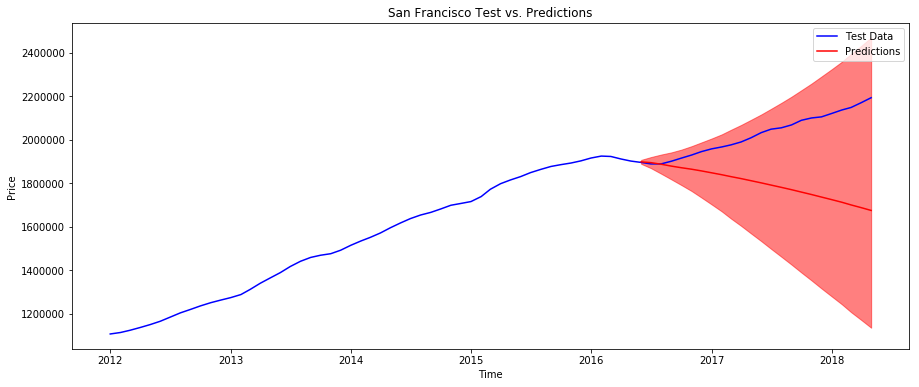

Test RSME: 275505.6193
Average Percent Error: 0.1069


In [71]:
forecast_score('San Francisco', sf_model_fit)

### San Mateo County

In [72]:
sm_train_log = np.log(sm_train)

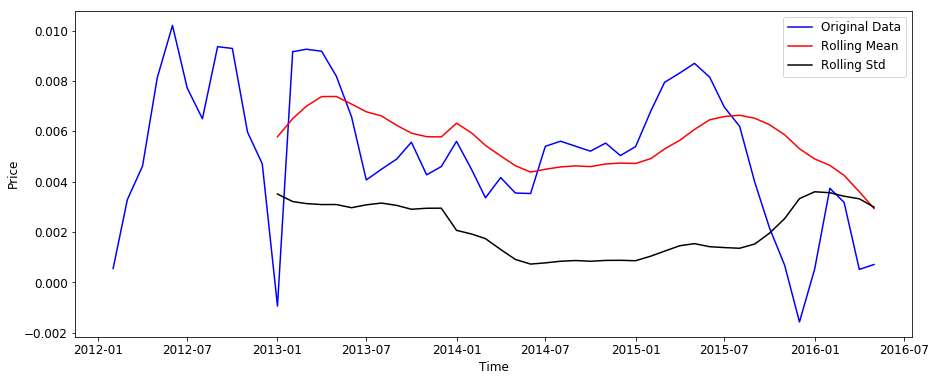

Test Statistic                 -3.125182
p-value                         0.024745
#Lags Used                      0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [73]:
sm_ma = moving_avg(sm_train_log, window=2)

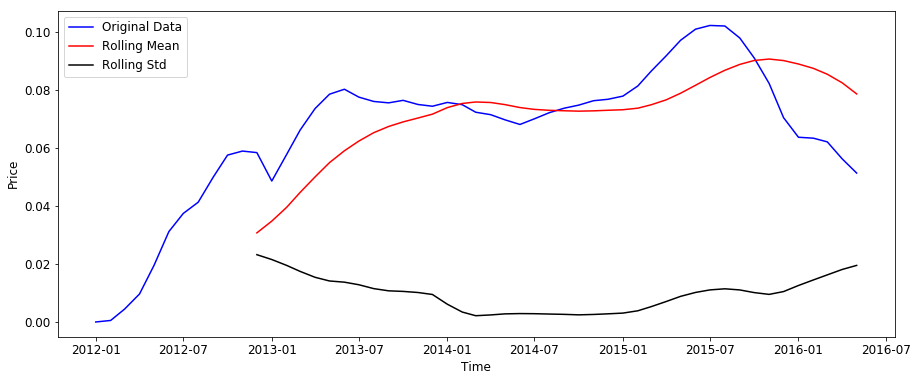

Test Statistic                 -3.126234
p-value                         0.024672
#Lags Used                      1.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [74]:
sm_wma = weighted_moving_avg(sm_train_log, hl=6)

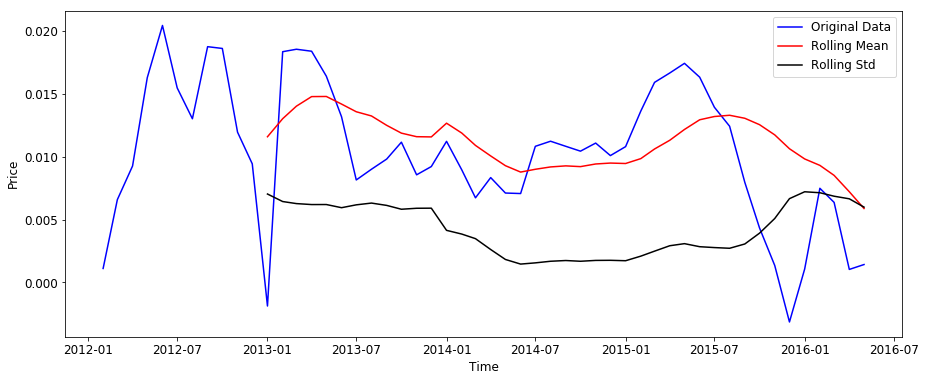

Test Statistic                 -3.125182
p-value                         0.024745
#Lags Used                      0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [75]:
sm_train_log_diff = differencing(sm_train_log, 1)

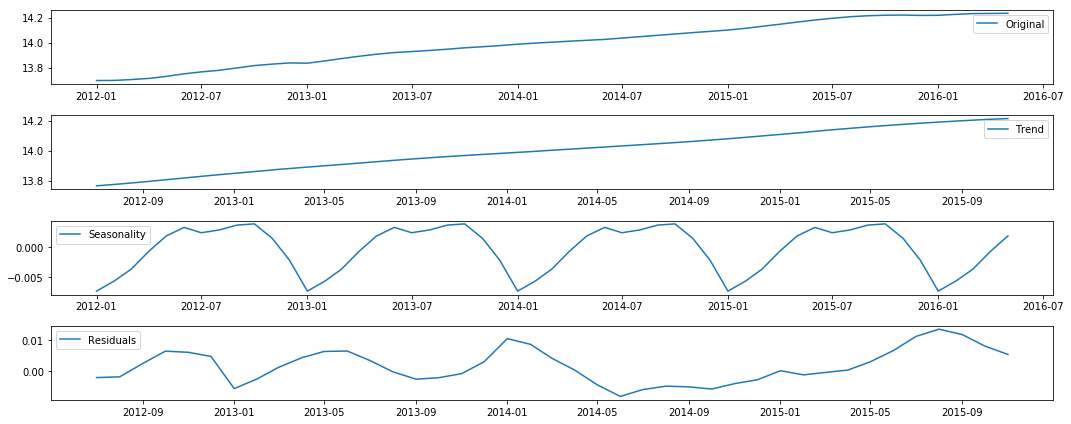

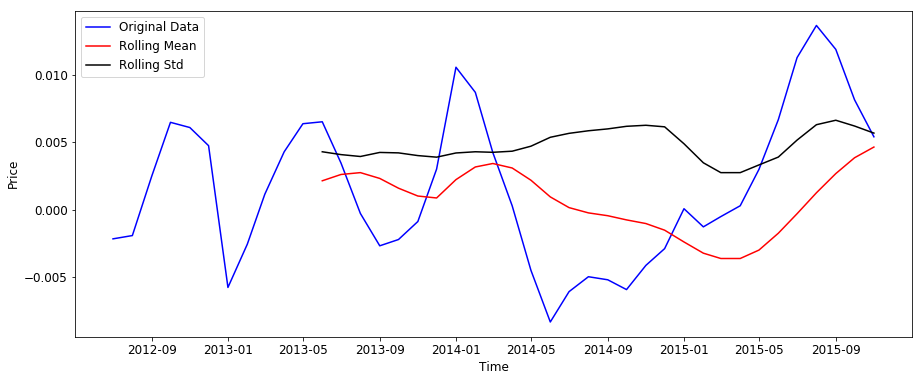

Test Statistic                 -3.456124
p-value                         0.009188
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [76]:
sm_train_resid = decomposing(sm_train_log)

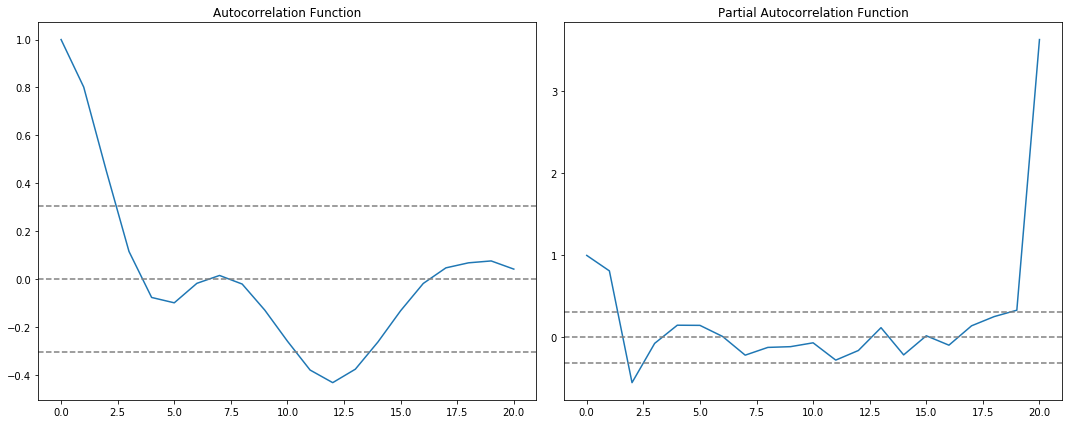

In [77]:
acf_pacf(sm_train_resid)

In [78]:
sm_train_p=3
sm_train_q=2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.San Mateo   No. Observations:                   51
Model:                 ARIMA(3, 2, 2)   Log Likelihood                 206.998
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sat, 21 Mar 2020   AIC                           -399.995
Time:                        16:40:38   BIC                           -386.472
Sample:                    03-01-2012   HQIC                          -394.828
                         - 05-01-2016                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0001   9.03e-05     -1.293      0.202      -0.000    6.02e-05
ar.L1.D2.San Mateo     0.2851      2.371      0.120      0.905      -4.361       4.932
ar.L2.D2.San Mateo  

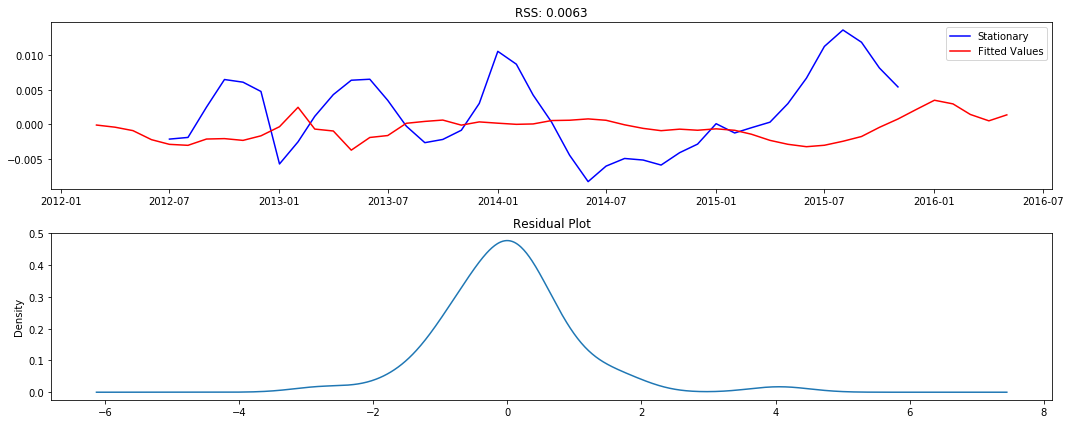

count    5.100000e+01
mean    -2.394599e-17
std      1.000000e+00
min     -2.731199e+00
25%     -5.995070e-01
50%      1.219161e-02
75%      3.414764e-01
max      4.054210e+00
dtype: float64


In [79]:
sm_model_fit = arima_summary(sm_train_log, sm_train_resid, sm_train_p, 2, sm_train_q)

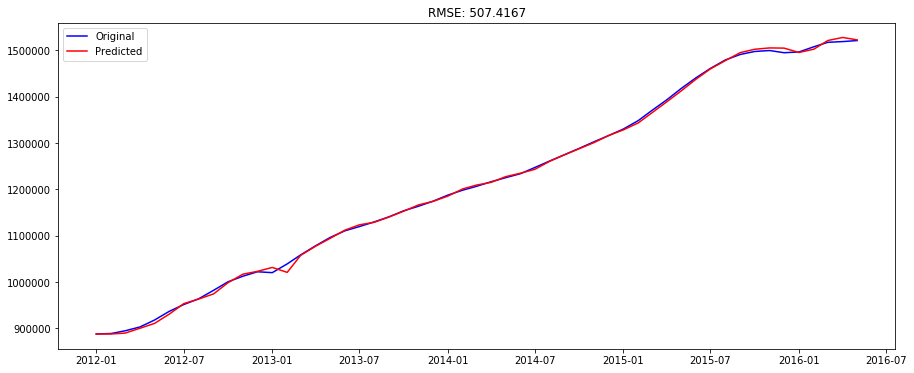

In [80]:
ARIMA_predictions('San Mateo', sm_model_fit)

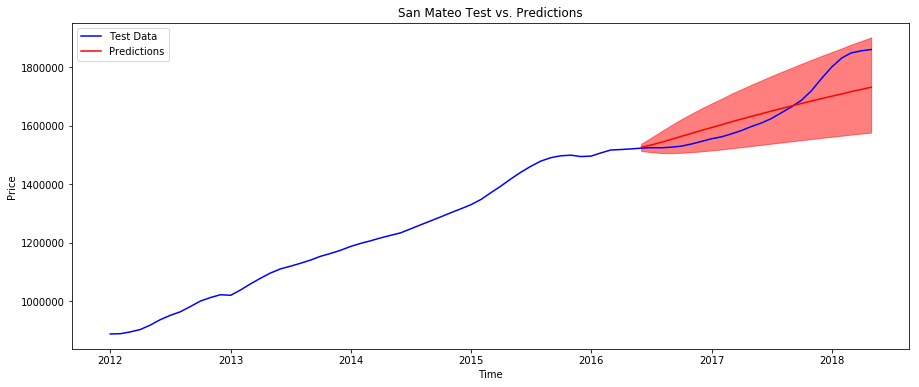

Test RSME: 63676.9132
Average Percent Error: 0.0283


In [81]:
forecast_score('San Mateo', sm_model_fit)

### Santa Clara County

In [82]:
sc_train_log = np.log(sc_train)

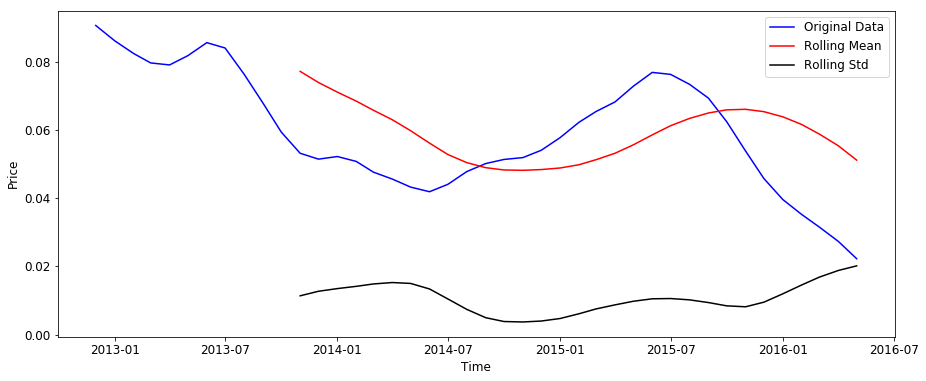

Test Statistic                 -2.910672
p-value                         0.044121
#Lags Used                      5.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [83]:
sc_ma = moving_avg(sc_train_log, window=12)

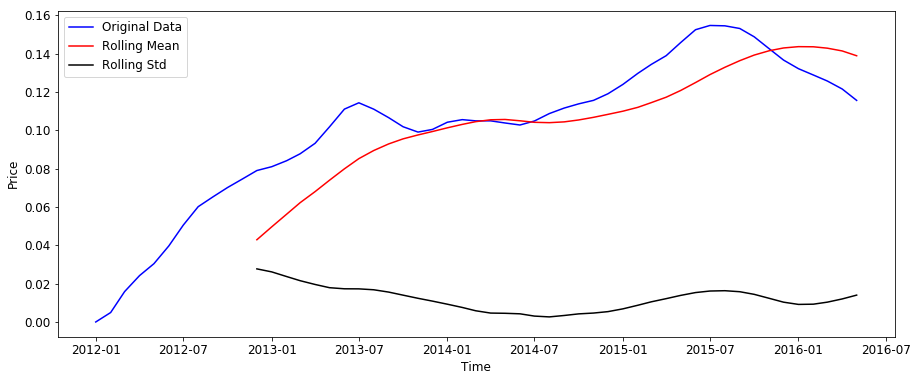

Test Statistic                 -1.939482
p-value                         0.313721
#Lags Used                     10.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [84]:
sc_wma = weighted_moving_avg(sc_train_log, hl=12)

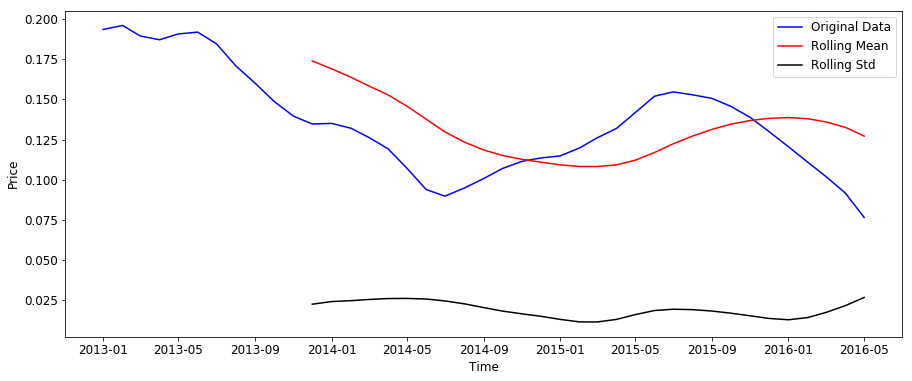

Test Statistic                 -0.505602
p-value                         0.890919
#Lags Used                     10.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [85]:
sc_train_log_diff = differencing(sc_train_log, 12)

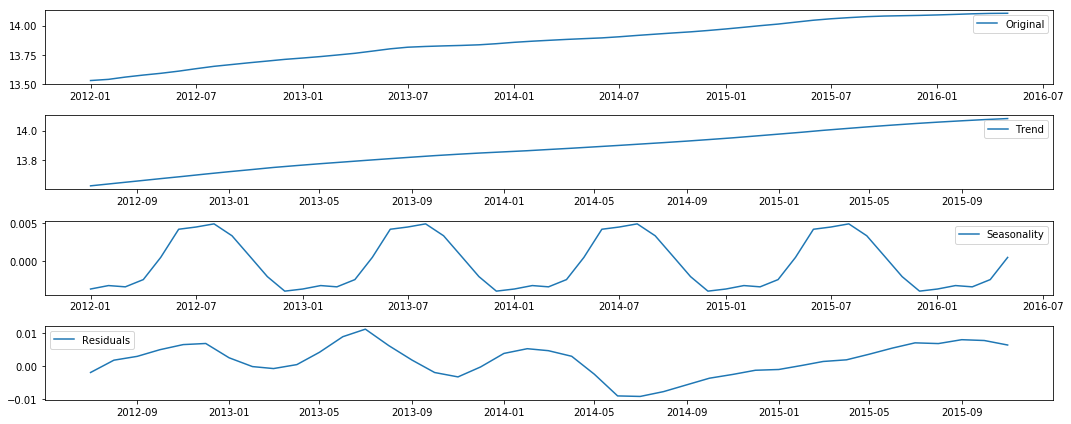

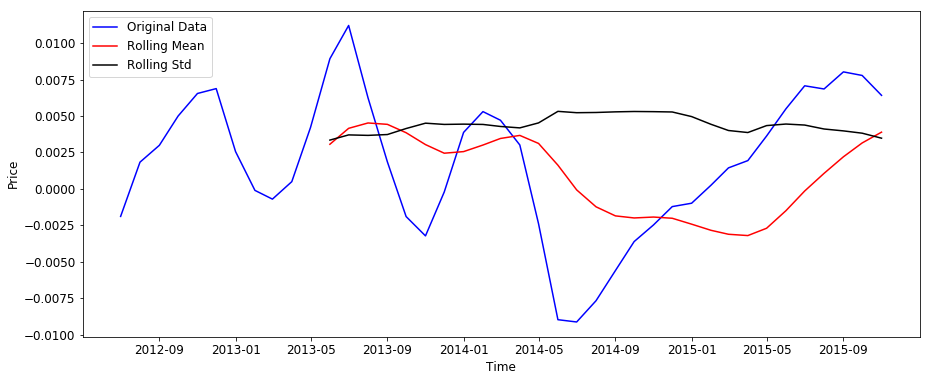

Test Statistic                 -2.388236
p-value                         0.145084
#Lags Used                      9.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [86]:
sc_train_resid = decomposing(sc_train_log)

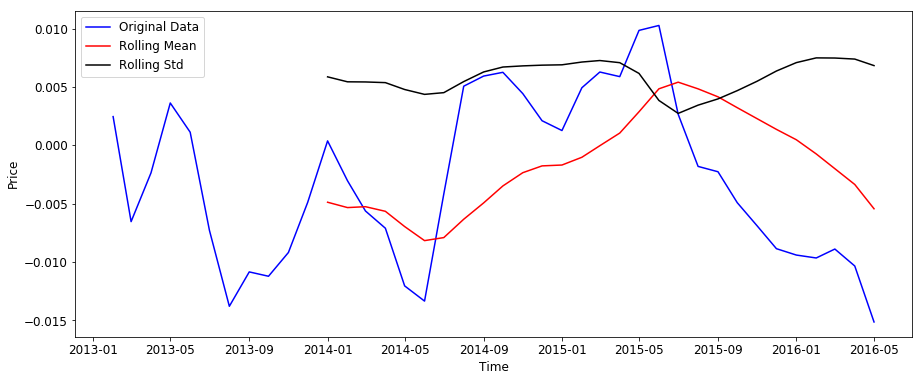

Test Statistic                 -2.697742
p-value                         0.074430
#Lags Used                      9.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [87]:
sc_double_diff = differencing(sc_train_log_diff, 1)

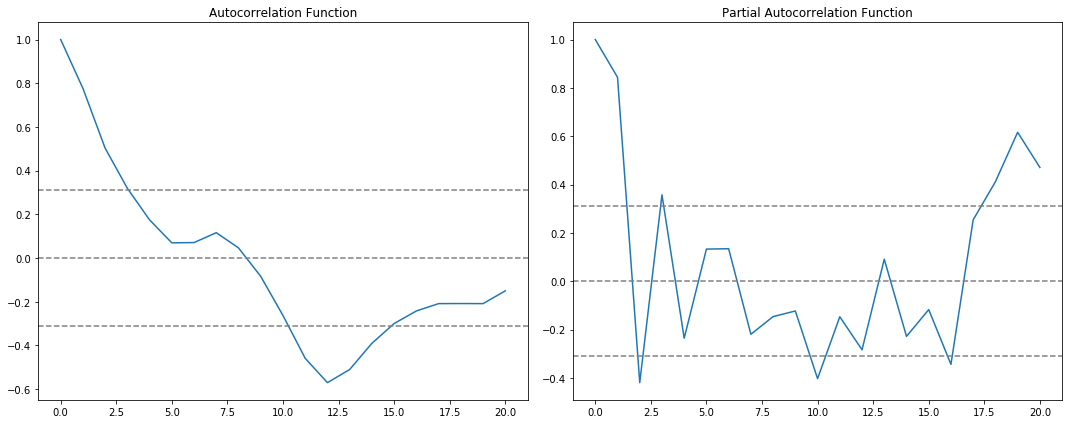

In [88]:
acf_pacf(sc_double_diff)

In [89]:
sc_train_p=3
sc_train_q=2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D2.Santa Clara   No. Observations:                   51
Model:                 ARIMA(3, 2, 2)   Log Likelihood                 239.822
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 21 Mar 2020   AIC                           -465.644
Time:                        16:40:48   BIC                           -452.122
Sample:                    03-01-2012   HQIC                          -460.477
                         - 05-01-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -8.581e-05      0.000     -0.190      0.850      -0.001       0.001
ar.L1.D2.Santa Clara    -0.7723      0.172     -4.497      0.000      -1.109      -0.436
ar.L2.D2.San

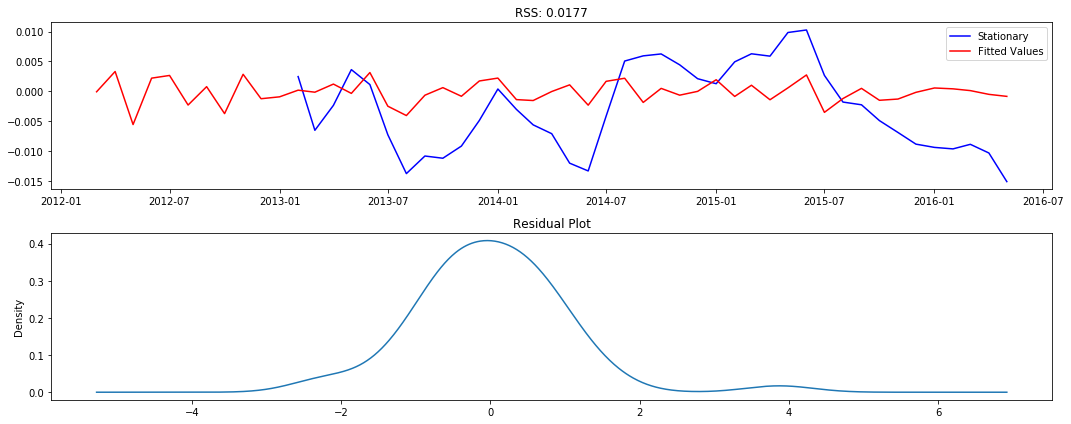

count    5.100000e+01
mean     6.530724e-18
std      1.000000e+00
min     -2.226125e+00
25%     -5.709927e-01
50%     -6.048548e-02
75%      6.202379e-01
max      3.869505e+00
dtype: float64


In [90]:
sc_model_fit = arima_summary(sc_train_log, sc_double_diff, sc_train_p, 2, sc_train_q)

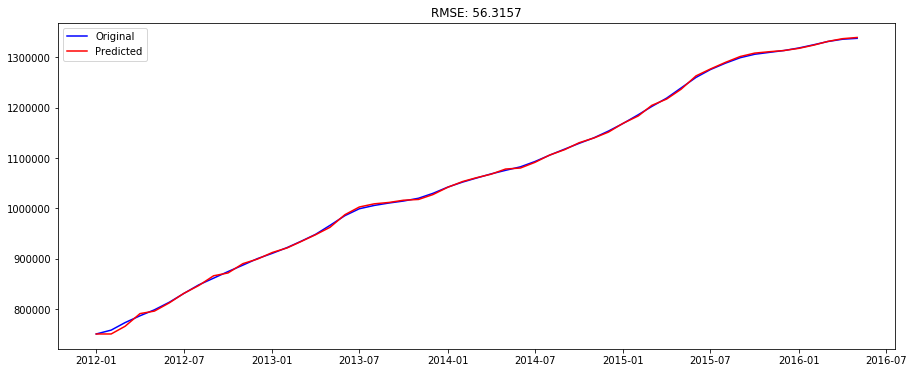

In [91]:
ARIMA_predictions('Santa Clara', sc_model_fit)

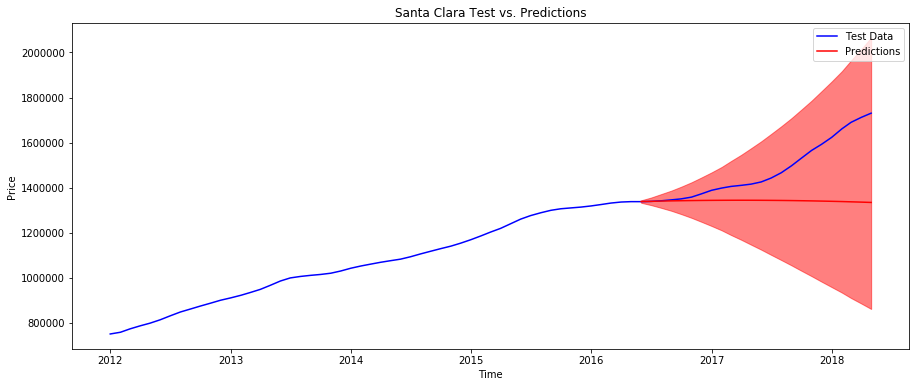

Test RSME: 186182.5765
Average Percent Error: 0.0842


In [92]:
forecast_score('Santa Clara', sc_model_fit)

### Solano County

In [93]:
solano_train_log = np.log(solano_train)

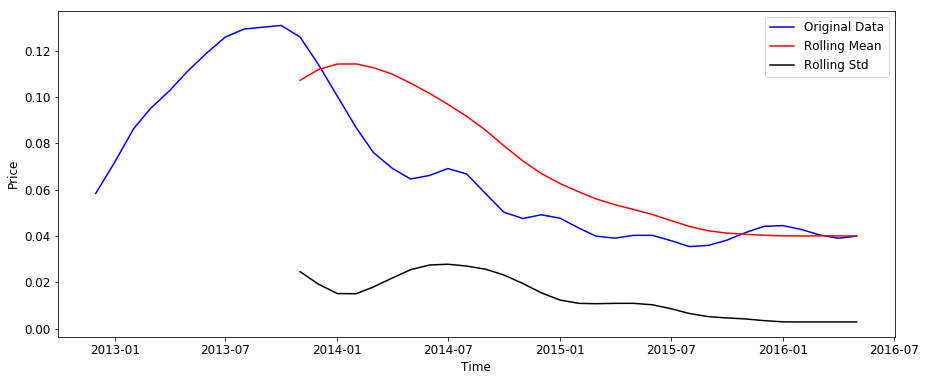

Test Statistic                 -2.146227
p-value                         0.226337
#Lags Used                      3.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [94]:
solano_ma = moving_avg(solano_train_log, window=12)

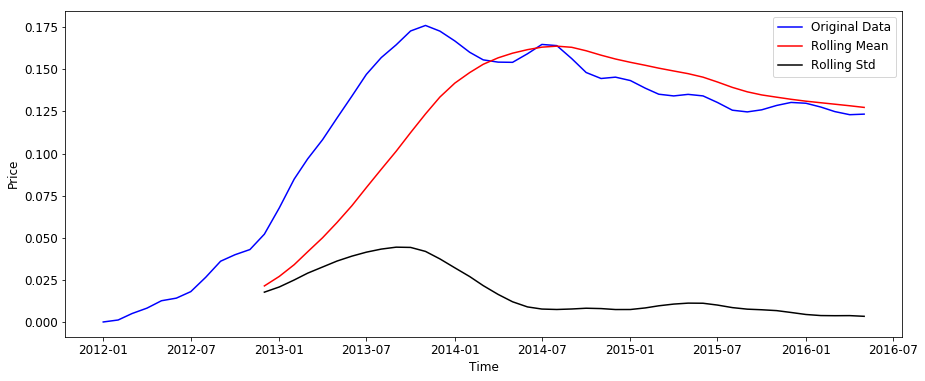

Test Statistic                 -2.943369
p-value                         0.040532
#Lags Used                      7.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [95]:
solano_wma = weighted_moving_avg(solano_train_log, hl=12)

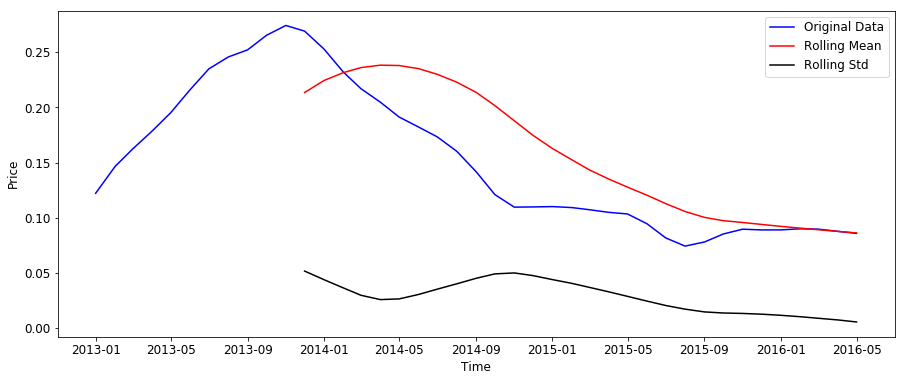

Test Statistic                 -2.810619
p-value                         0.056773
#Lags Used                      9.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [96]:
solano_train_log_diff = differencing(solano_train_log, 12)

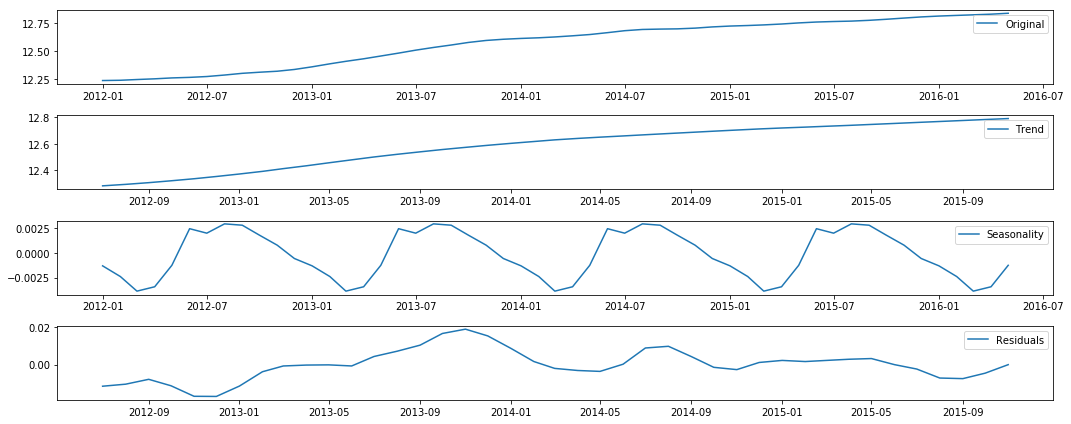

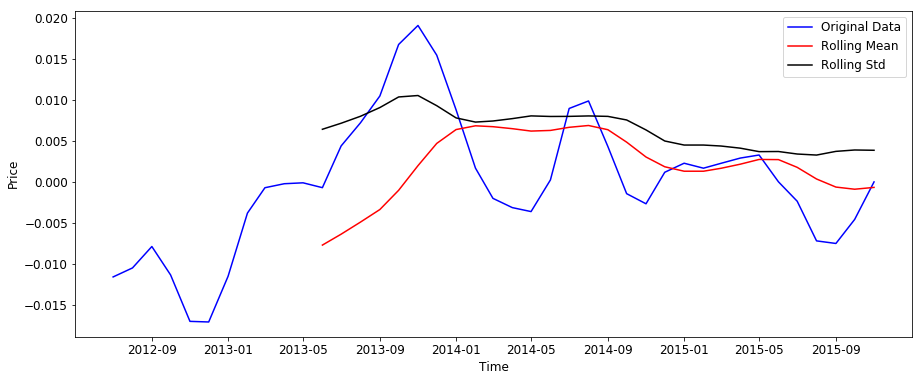

Test Statistic                 -3.357600
p-value                         0.012492
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [97]:
solano_train_resid = decomposing(solano_train_log)

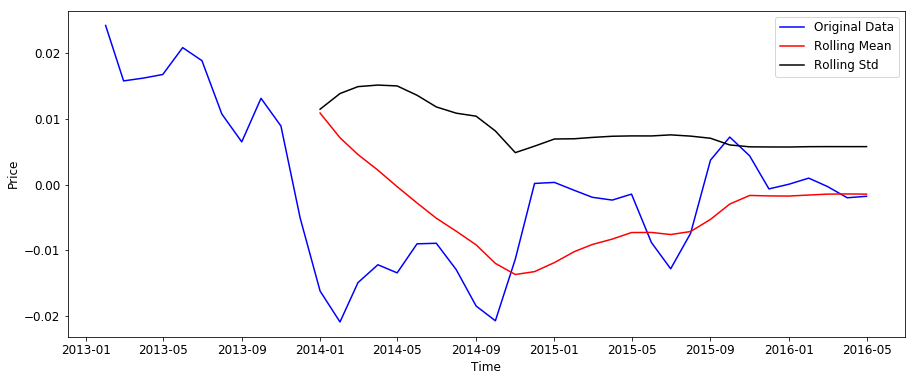

Test Statistic                 -4.996932
p-value                         0.000023
#Lags Used                      8.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [98]:
solano_double_diff = differencing(solano_train_log_diff, 1)

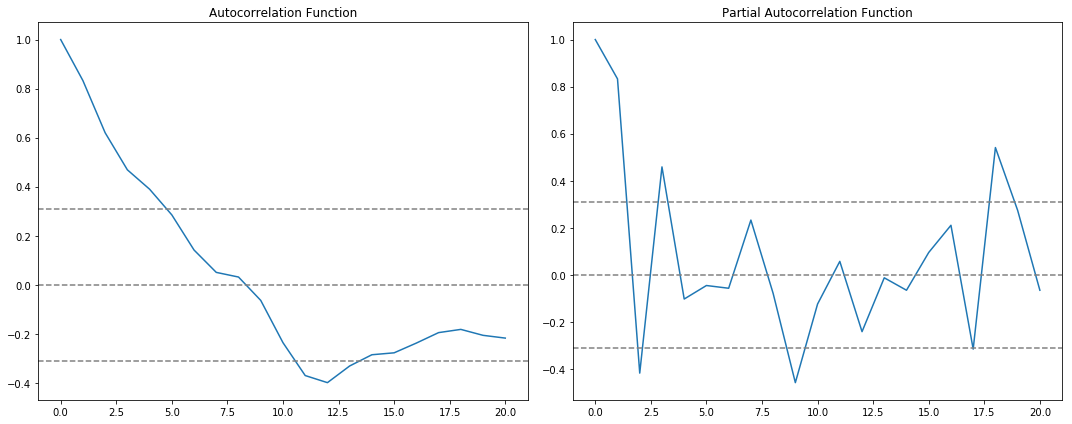

In [99]:
acf_pacf(solano_double_diff)

In [100]:
solano_train_p = 5
solano_train_q = 2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\Curtis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Curtis\Anaconda3\lib\site-packages\scipy\stats\_dis

                             ARIMA Model Results                              
Dep. Variable:              D2.Solano   No. Observations:                   51
Model:                 ARIMA(5, 2, 2)   Log Likelihood                 230.314
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 21 Mar 2020   AIC                           -442.629
Time:                        16:41:00   BIC                           -425.242
Sample:                    03-01-2012   HQIC                          -435.985
                         - 05-01-2016                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.413e-06      0.000     -0.020      0.984      -0.000       0.000
ar.L1.D2.Solano     1.1629        nan        nan        nan         nan         nan
ar.L2.D2.Solano    -0.4533      

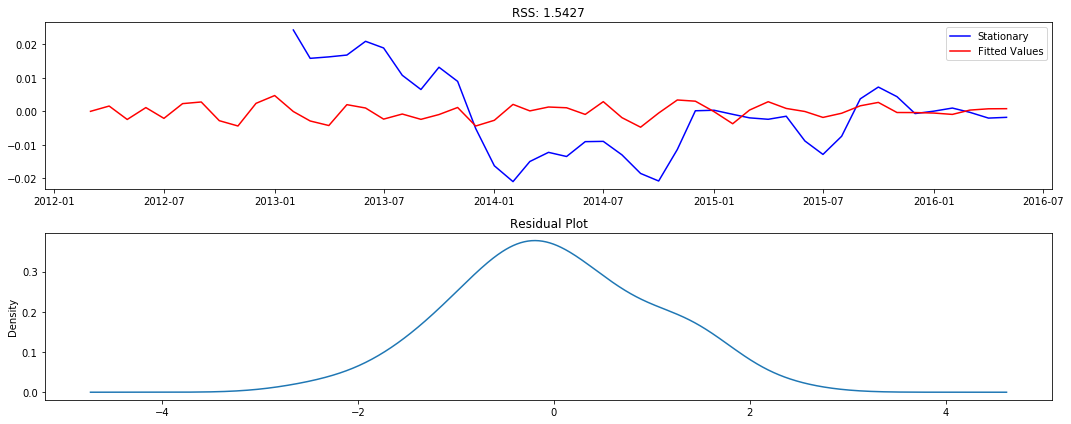

count    5.100000e+01
mean     2.068062e-17
std      1.000000e+00
min     -2.392184e+00
25%     -6.596005e-01
50%     -9.104917e-02
75%      6.014725e-01
max      2.284580e+00
dtype: float64


In [101]:
solano_model_fit = arima_summary(solano_train_log, solano_double_diff, solano_train_p, 2, solano_train_q)

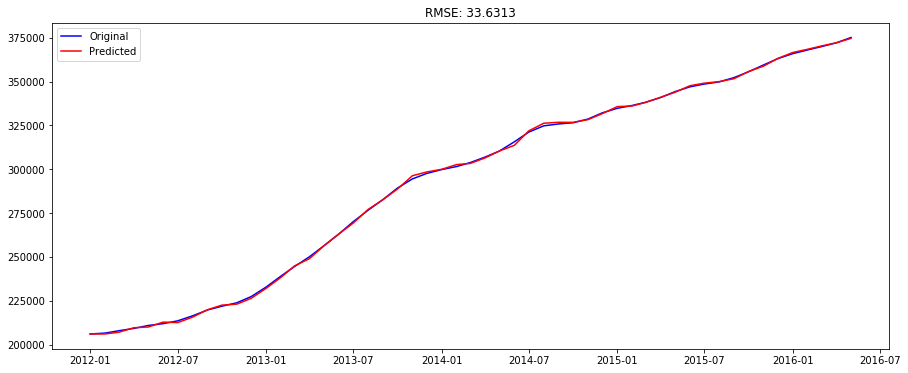

In [102]:
ARIMA_predictions('Solano', solano_model_fit)

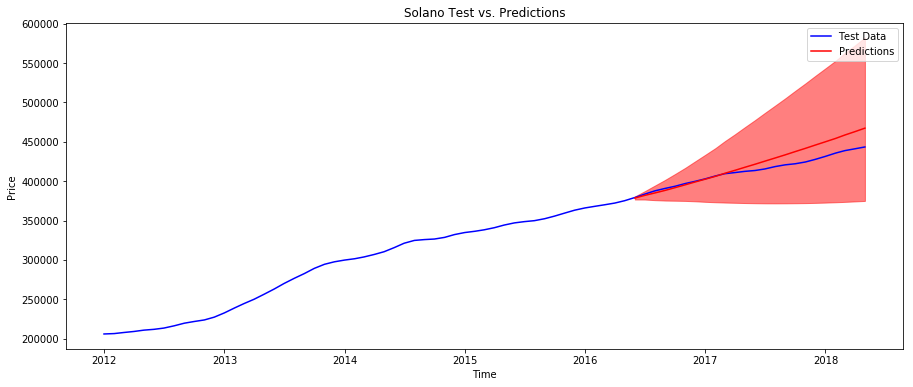

Test RSME: 12061.3198
Average Percent Error: 0.0211


In [103]:
forecast_score('Solano', solano_model_fit)

### Sonoma County

In [104]:
sonoma_train_log = np.log(sonoma_train)

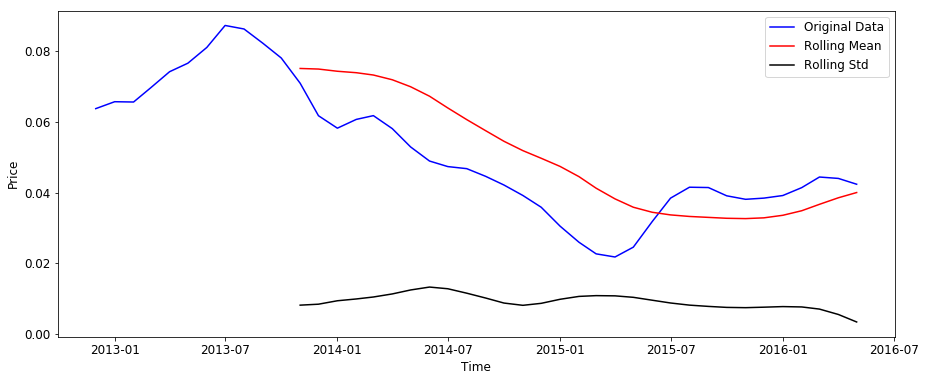

Test Statistic                 -2.626714
p-value                         0.087601
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [105]:
sonoma_ma = moving_avg(sonoma_train_log, window=12)

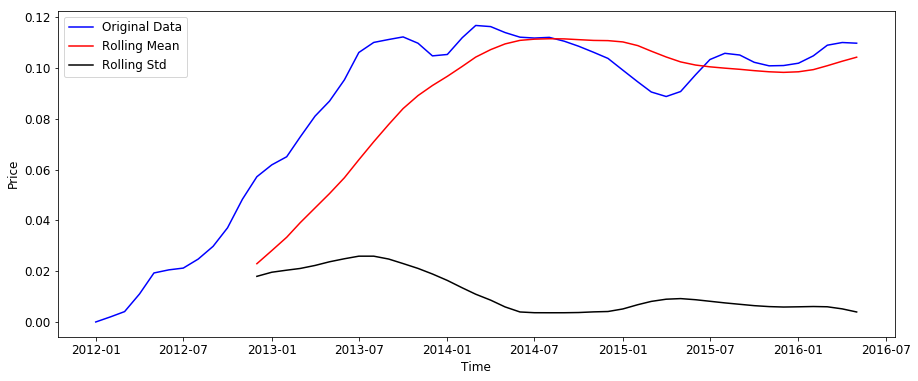

Test Statistic                 -3.164507
p-value                         0.022133
#Lags Used                      6.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [106]:
sonoma_wma = weighted_moving_avg(sonoma_train_log, hl=12)

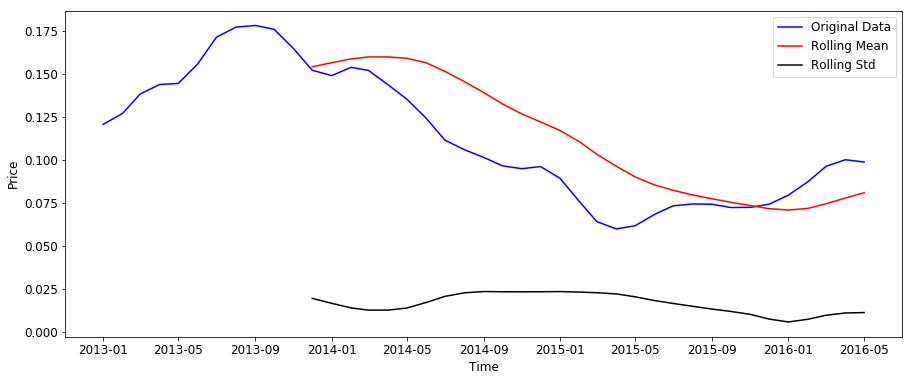

Test Statistic                 -4.756500
p-value                         0.000066
#Lags Used                     10.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [107]:
sonoma_train_log_diff = differencing(sonoma_train_log, 12)

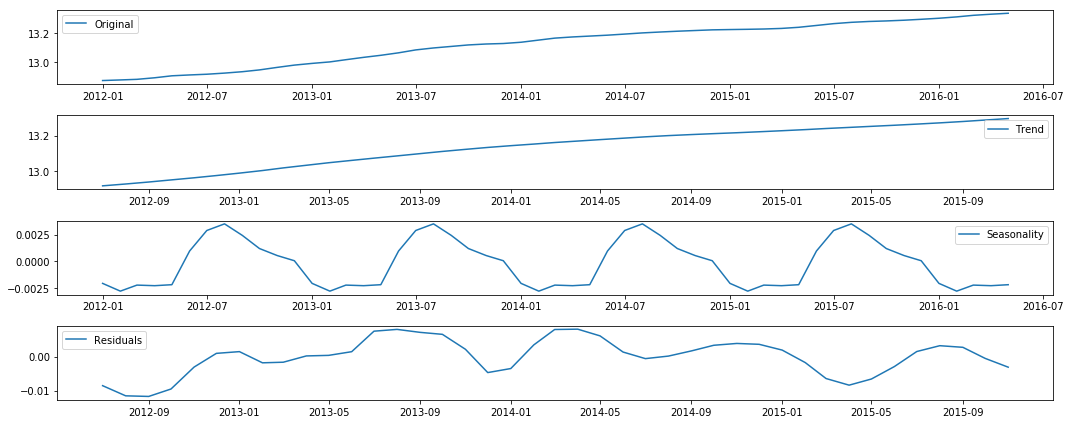

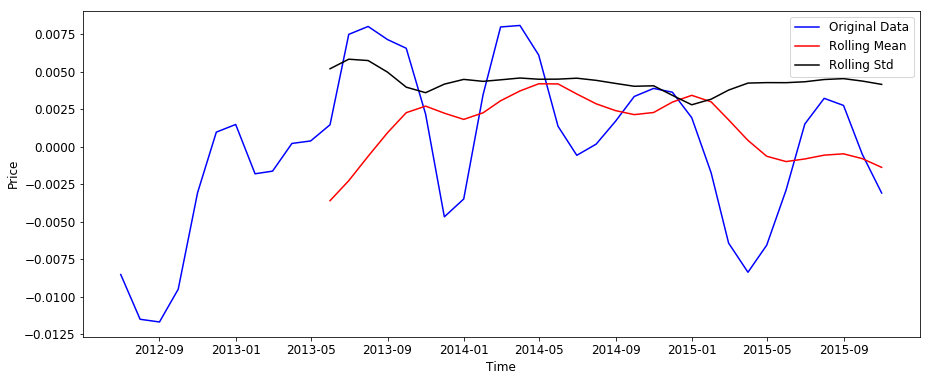

Test Statistic                 -2.595547
p-value                         0.093921
#Lags Used                     10.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [108]:
sonoma_train_resid = decomposing(sonoma_train_log)

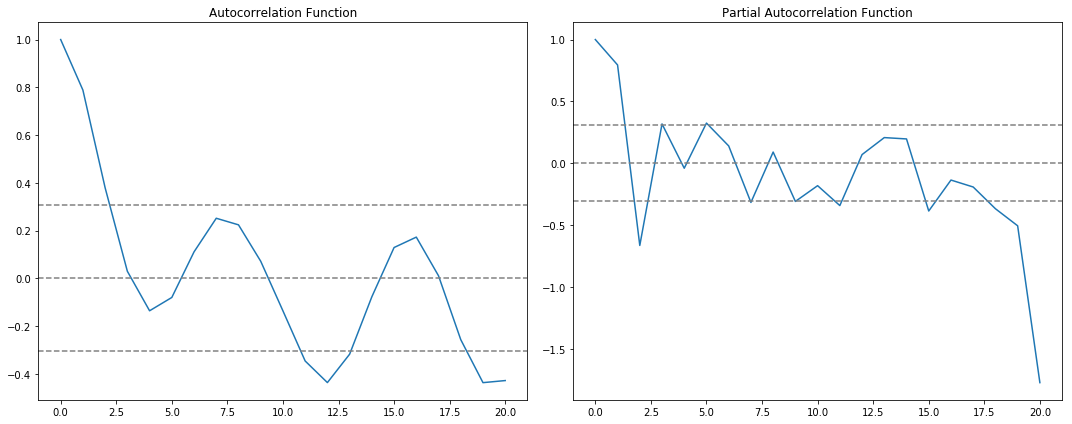

In [109]:
acf_pacf(sonoma_train_resid)

In [110]:
sonoma_train_p=3
sonoma_train_q=2

C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Curtis\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D2.Sonoma   No. Observations:                   51
Model:                 ARIMA(3, 2, 2)   Log Likelihood                 234.449
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sat, 21 Mar 2020   AIC                           -454.897
Time:                        16:42:01   BIC                           -441.374
Sample:                    03-01-2012   HQIC                          -449.730
                         - 05-01-2016                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.342e-05   8.47e-05     -0.867      0.391      -0.000    9.25e-05
ar.L1.D2.Sonoma     0.8965      0.191      4.687      0.000       0.522       1.271
ar.L2.D2.Sonoma    -0.5387      

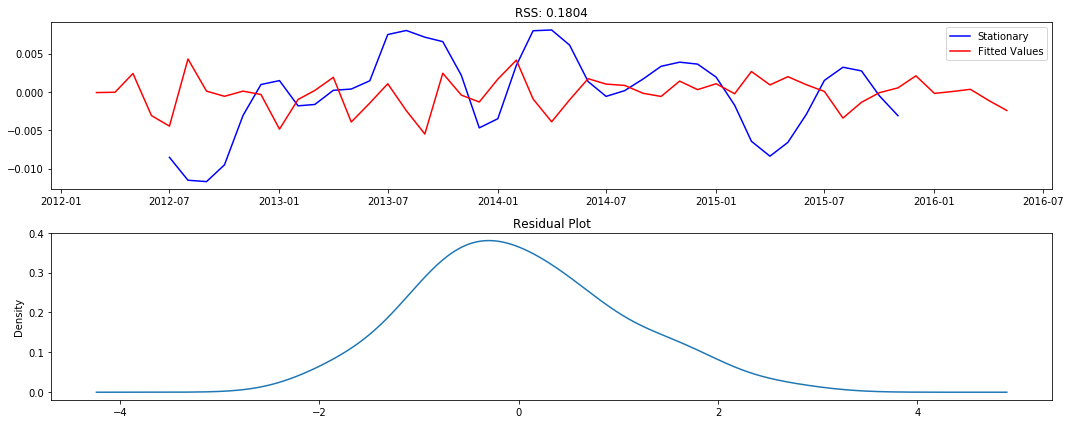

count    5.100000e+01
mean     1.088454e-18
std      1.000000e+00
min     -1.952269e+00
25%     -6.988645e-01
50%     -1.373592e-01
75%      6.291874e-01
max      2.613215e+00
dtype: float64


In [111]:
sonoma_model_fit = arima_summary(sonoma_train_log, sonoma_train_resid, sonoma_train_p, 2, sonoma_train_q)

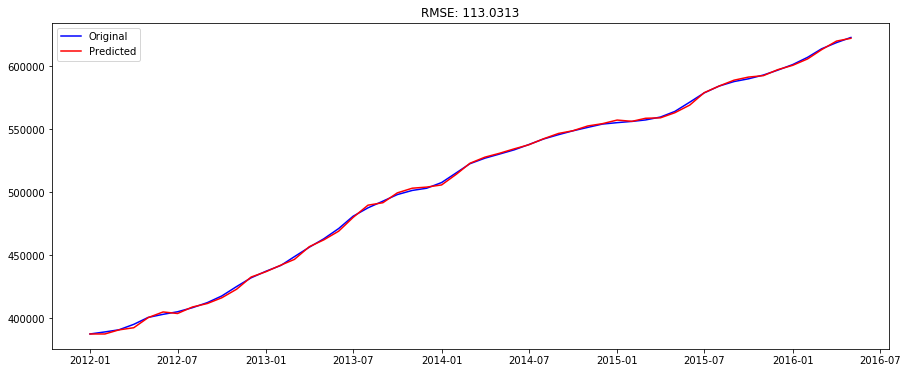

In [112]:
ARIMA_predictions('Sonoma', sonoma_model_fit)

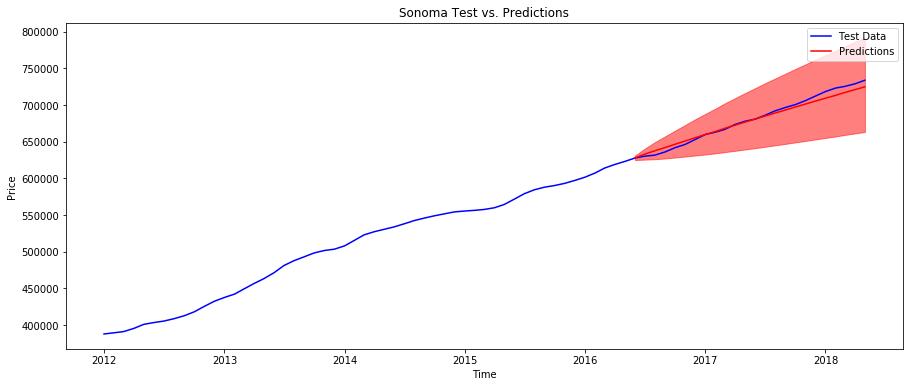

Test RSME: 5106.3798
Average Percent Error: 0.0059


In [113]:
forecast_score('Sonoma', sonoma_model_fit)